# 1. Import Packages and Define Useful Functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense,Activation,GRU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D, BatchNormalization,UnitNormalization,LayerNormalization
from tensorflow.keras.layers import MaxPooling1D, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM,TimeDistributed

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
def data_preprocess(df):
    '''
    This function would drop unrelated columns in the dataframe 
    sort the data based on case number, create time and item description
    and calculate hours for each patient seperately.
    '''
    icu_data_select = df[['Case Number', 'Item Description', 'Value Text','Created Datetime']]
    print("Total rows before dropping duplicates: {0}".format(len(icu_data_select)))
    icu_data_select = icu_data_select.drop_duplicates()
    print("Total rows after dropping duplicates: {0}".format(len(icu_data_select)))
    icu_data_sorted = icu_data_select.sort_values(by=['Case Number', 'Created Datetime', 'Item Description'])
    icu_data_sorted = icu_data_sorted.reset_index(drop=True)
    icu_data_sorted['Time'] = icu_data_sorted['Created Datetime'] - icu_data_sorted['Created Datetime'].min()
    icu_data_sorted['Hours'] = icu_data_sorted['Time'] / pd.Timedelta(hours=1)
    l = len(icu_data_sorted['Case Number'].unique())
    for i in range(1,l+1):
        if i < 10:
            case_num = 'case_00' + str(i)
        else: case_num = 'case_0' + str(i)
        icu_data_sorted.loc[icu_data_sorted['Case Number'] == case_num,['Hours']]  = icu_data_sorted.loc[icu_data_sorted['Case Number'] == case_num,['Hours']] - icu_data_sorted.loc[icu_data_sorted['Case Number'] == case_num,['Hours']].min()
    icu_data_sorted = icu_data_sorted.dropna()
    return icu_data_sorted

def plot_ventilator(df, case_number, item):
    df_plot = df.loc[(df['Case Number']==case_number) & (df['Item Description']==item)]
    df_plot.plot(x='Hours', y='Value Text')
    plt.scatter(df_plot['Hours'], df_plot['Value Text'])
    plt.plot(df_plot['Hours'], df_plot['Value Text'])
    
def plot_ventilator_all(case_number, df):
    df_case = df[df['Case Number']==case_number]
    features = ['Ventilator Reading ETCO2',
                #'Ventilator Reading Peak Inspiratory Pressure/Ppeak',
                'Ventilator Reading Respiratory Rate (breaths/min)',
                'Ventilator Reading VT Exhaled',
               ]
    # define subplot grid
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(case_number, fontsize=18, y=0.95)
    # loop through tickers and axes
    for feature, ax in zip(features, axs.ravel()):
        # filter df for ticker and plot on specified axes
        df_feature = df_case[df_case["Item Description"] == feature]
        ax.scatter(df_feature['Hours'], df_feature['Value Text'],color='orange')
        ax.plot(df_feature['Hours'], df_feature['Value Text'])
        # chart formatting
        ax.set_title(feature)
        #ax.get_legend().remove()
        ax.set_xlabel("Hour")

    plt.show()
    
def plot_indi_intubation(df_case):
    case_number = df_case.loc[0,'Case Number']
    features = ['Ventilator Reading ETCO2',
                #'Ventilator Reading Peak Inspiratory Pressure/Ppeak',
                'Ventilator Reading Respiratory Rate (breaths/min)',
                'Ventilator Reading VT Exhaled',
               ]
    # define subplot grid
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle(case_number, fontsize=18, y=0.95)
    # loop through tickers and axes
    for feature, ax in zip(features, axs.ravel()):
        # filter df for ticker and plot on specified axes
        df_feature = df_case[df_case["Item Description"] == feature]
        ax.scatter(df_feature['Hours'], df_feature['Value Text'],color='orange')
        ax.plot(df_feature['Hours'], df_feature['Value Text'])
        # chart formatting
        ax.set_title(feature)
        #ax.get_legend().remove()
        ax.set_xlabel("Hour")

    plt.show()
    
    
def plot_case_duration(df):
    time_data = df.groupby('Case Number')['Created Datetime'].agg(['min','max'])
    time_data['Duration'] = time_data['max'] - time_data['min']
    time_data['Hours'] = time_data['Duration'] / pd.Timedelta(hours=1)
    time_data['Hours'].plot.bar(xlabel='Case Number', title='ICU Duration in Hours')

def plot_case_record(df):
    df.groupby('Case Number')['Value Text'].count().plot.bar(xlabel='Case Number', title='Number of available ventilator data per case')
    
def intubation_split(df,case_num):
    '''
    split the cases with multiple MV to each single MV
    '''
    split_list = []
    df_list = []
    intubation_time_list = []
    
    df_case = df.loc[df['Case Number']==case_num]
    df_case = df_case.reset_index(drop=True)
    for index, row in df_case.iterrows():
        if index == 0:
            continue
        if (df_case.loc[index,'Hours'] - df_case.loc[index-1,'Hours'] >= 5) :
            split_list.append(index-1)
    
    start_index = -1
    for split_index in split_list:
        df_split = df_case.iloc[start_index+1:split_index]
        df_split = df_split.reset_index(drop=True)
        df_split.loc[:,'Hours'] = df_split.loc[:,'Hours'] - df_split.loc[:,'Hours'].min()
        intubation_time_list.append(df_split['Hours'].max())
        df_list.append(df_split)
        start_index = split_index
        
    df_split = df_case.iloc[start_index+1:]
    df_split = df_split.reset_index(drop=True)
    df_split.loc[:,'Hours'] = df_split.loc[:,'Hours'] - df_split.loc[:,'Hours'].min()
    intubation_time_list.append(df_split['Hours'].max())
    df_list.append(df_split)

    return df_list,intubation_time_list

def total_intubation_split(df):
    df_list = []
    intubation_time_list = []
    case_list = ['case_001','case_005','case_006','case_007','case_008','case_009','case_010','case_011','case_014','case_015','case_016','case_017', 'case_019', 'case_021', 'case_022', 'case_023', 'case_024', 'case_025','case_026', 'case_027', 'case_028', 'case_029', 'case_030','case_031', 'case_032', 'case_034', 'case_035']
    #case_list = ['case_018']
    for case_num in case_list:
        df_list_small,intubation_time_list_small = intubation_split(df,case_num)
        df_list.extend(df_list_small)
        intubation_time_list.extend(intubation_time_list_small)
    return df_list,intubation_time_list

def sliding_window(window_size, slide, X, y):  
    
    i = 0
    data_list = []
    label_list = []
    num = len(X)
    
    while i < num-window_size+1 :
        single_window = []
        for j in range(window_size):
            single_window.append(X[i+j])
        data_list.append(single_window)
        label_list.append(y[i])
        i = i + slide
    
    return data_list,label_list

def remove_small_dfs(df_list, intubation_time_list):
    new_list = []
    new_time = []
    for i in range(len(df_list)):
        df_i = df_list[i]
        if len(df_i[df_i['Item Description']=='Ventilator Reading ETCO2'].notnull()) >= 10 and len(df_i[df_i['Item Description']=='Ventilator Reading VT Exhaled'].notnull()) >= 10 and len(df_i[df_i['Item Description']=='Ventilator Reading Respiratory Rate (breaths/min)'].notnull()) >= 10:
            new_list.append(df_i)
            new_time.append(intubation_time_list[i])
    return new_list, new_time

# 2. Data cleansing & pre-processing

In [4]:
#data file of 17 patients
path = 'C:/Users/wdhzw/Desktop/FYP_2023/data/ventilator_17_patients_amanda.xlsx'
icu_data_1 = pd.read_excel(path)
#data file of 19 patients
path = 'C:/Users/wdhzw/Desktop/FYP_2023/data/ventilator_19_patients_amanda.xlsx'
icu_data_2 = pd.read_excel(path)

icu_data = [icu_data_1, icu_data_2]
icu_data = pd.concat(icu_data)

df = data_preprocess(icu_data)

#Choose three features
feature_list = ['Ventilator Reading ETCO2',
                'Ventilator Reading Respiratory Rate (breaths/min)',
                'Ventilator Reading VT Exhaled',
               ]
df = df[df['Item Description'].isin(feature_list)]
df = df.reset_index(drop=True)
df['Case Number'].value_counts()

Total rows before dropping duplicates: 75233
Total rows after dropping duplicates: 55463


case_018    3570
case_001    2506
case_028    1437
case_031    1077
case_025     985
case_014     835
case_010     658
case_008     508
case_022     477
case_027     467
case_016     449
case_023     368
case_019     349
case_017     340
case_029     338
case_034     334
case_015     333
case_007     278
case_035     270
case_026     255
case_032     204
case_005     196
case_011     194
case_024     177
case_012     164
case_009     146
case_013      83
case_021      60
case_006      50
case_030      45
case_036      23
case_033       3
Name: Case Number, dtype: int64

In [5]:
icu_data['Item Description'].unique()

array(['Ventilator Reading ETCO2',
       'Ventilator Reading Peak Inspiratory Pressure/Ppeak',
       'Ventilator Reading Respiratory Rate (breaths/min)',
       'Ventilator Reading VT Exhaled', 'Ventilator Setting Changed By',
       'Ventilator Setting FiO2 (%)', 'Ventilator Setting Mode',
       'Ventilator Setting PEEP (cmH20)',
       'Ventilator Setting Set Respiratory Rate (breaths/min)',
       'Ventilator Setting Ti (s)',
       'Ventilator Setting Tidal Volume (mL)',
       'm-CPOT Ventilator Compliance or Vocalization Score for Nurse Charting Vital Signs',
       'm-CPOT Ventilator Compliance or Vocalization for Nurse Charting Vital Signs',
       'Ventilator Setting PHigh', 'Ventilator Setting PLow',
       'Ventilator Setting THigh', 'Ventilator Setting TLow',
       'Ventilator Setting PS', 'Ventilator Setting Remarks',
       'Ventilator Reading (Respiratory Therapist) MAP',
       'Ventilator Reading (Respiratory Therapist) VE L/min',
       'Ventilator Setting E Ratio

Text(0, 0.5, 'Frequency')

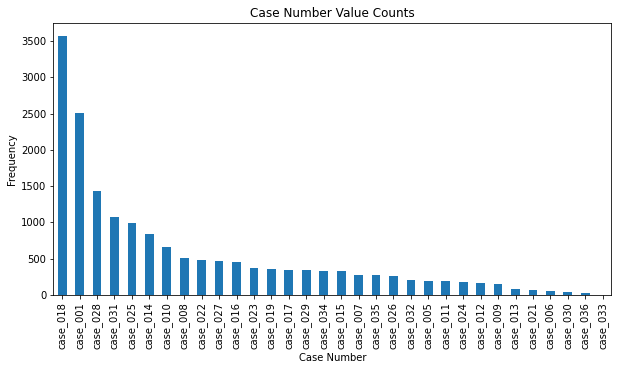

In [48]:
# Calculate the value counts for 'Case Number'
case_counts = df['Case Number'].value_counts()

# Create a bar plot of the value counts
case_counts.plot(kind='bar', figsize=(10, 5))

# Set plot title and axis labels
plt.title('Case Number Value Counts')
plt.xlabel('Case Number')
plt.ylabel('Frequency')

In [6]:
df

Case Number                                   Item Description  \
0        case_001                           Ventilator Reading ETCO2   
1        case_001                           Ventilator Reading ETCO2   
2        case_001  Ventilator Reading Respiratory Rate (breaths/min)   
3        case_001  Ventilator Reading Respiratory Rate (breaths/min)   
4        case_001  Ventilator Reading Respiratory Rate (breaths/min)   
...           ...                                                ...   
17174    case_036                           Ventilator Reading ETCO2   
17175    case_036  Ventilator Reading Respiratory Rate (breaths/min)   
17176    case_036                      Ventilator Reading VT Exhaled   
17177    case_036  Ventilator Reading Respiratory Rate (breaths/min)   
17178    case_036                      Ventilator Reading VT Exhaled   

      Value Text    Created Datetime               Time     Hours  
0             49 2020-01-01 12:05:07 1014 days 21:46:57  0.000000  
1             56 2020-01-01 12:05:07 1014 days 21:46:57  0.000000  
2             32 2020-01-01 12:05:07 1014 days 21:46:57  0.000000  
3             36 2020-01-01 12:05:07 1014 days 21:46:57  0.000000  
4             38 2020-01-01 12:05:07 1014 days 21:46:57  0.000000  
...          ...                 ...                ...       ...  
17174         17 2019-07-27 18:42:02  857 days 04:23:52  6.577778  
17175         18 2019-07-27 18:42:02  857 days 04:23:52  6.577778  
17176        312 2019-07-27 18:42:02  857 days 04:23:52  6.577778  
17177         18 2019-07-27 19:36:20  857 days 05:18:10  7.482778  
17178        322 2019-07-27 19:36:20  857 days 05:18:10  7.482778  

[17179 rows x 6 columns]

In [7]:
#Get individual MV
df_list,intubation_time_list = total_intubation_split(df)

In [8]:
df_list,intubation_time_list = remove_small_dfs(df_list, intubation_time_list)
print(len(df_list))

40


In [9]:
# remove case_001 (outlier)
remove = True
if remove:
    for i in range(3):
        df_list.pop(0)
        intubation_time_list.pop(0)

In [10]:
len(intubation_time_list)

37

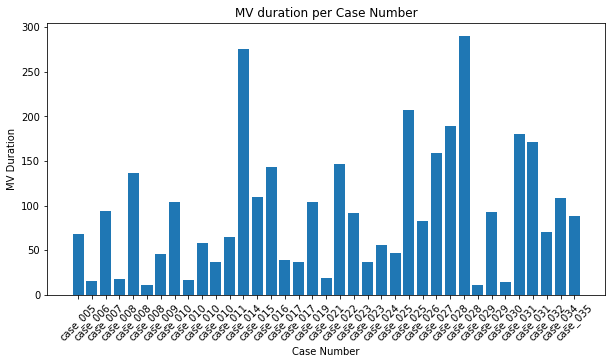

In [11]:
import matplotlib.pyplot as plt

case_list_bar = []
for i in df_list:
    case_list_bar.append(i['Case Number'].unique()[0])

# Create an index list for the x-axis
index_list = list(range(len(intubation_time_list)))

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(index_list, intubation_time_list)

# Set plot title and axis labels
ax.set_title('MV duration per Case Number')
ax.set_xlabel('Case Number')
ax.set_ylabel('MV Duration')

# Set custom labels for x-axis ticks
ax.set_xticks(index_list)
ax.set_xticklabels(case_list_bar, rotation=45)

# Show the plot
plt.show()


# 3. Data Visualization

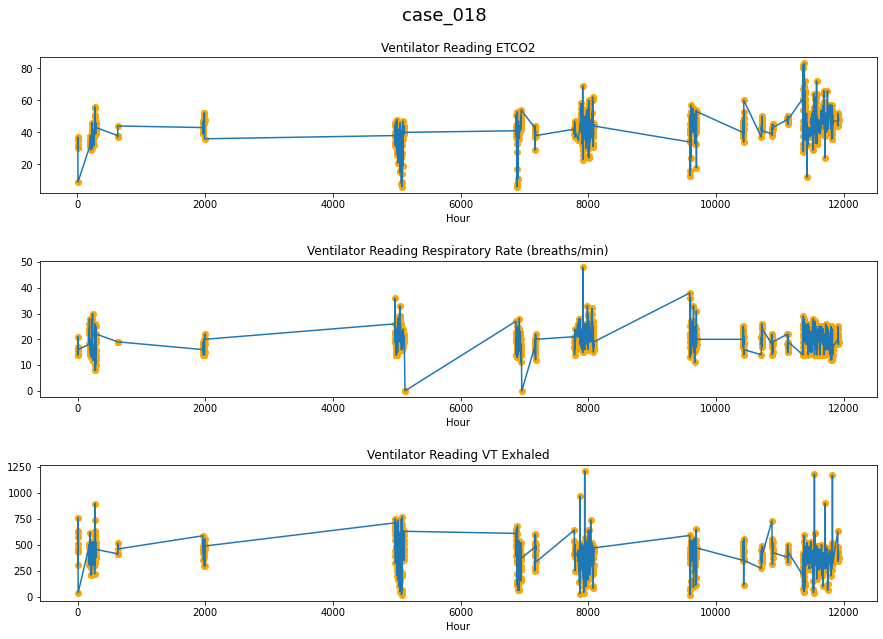

In [12]:
plot_ventilator_all('case_018',df)

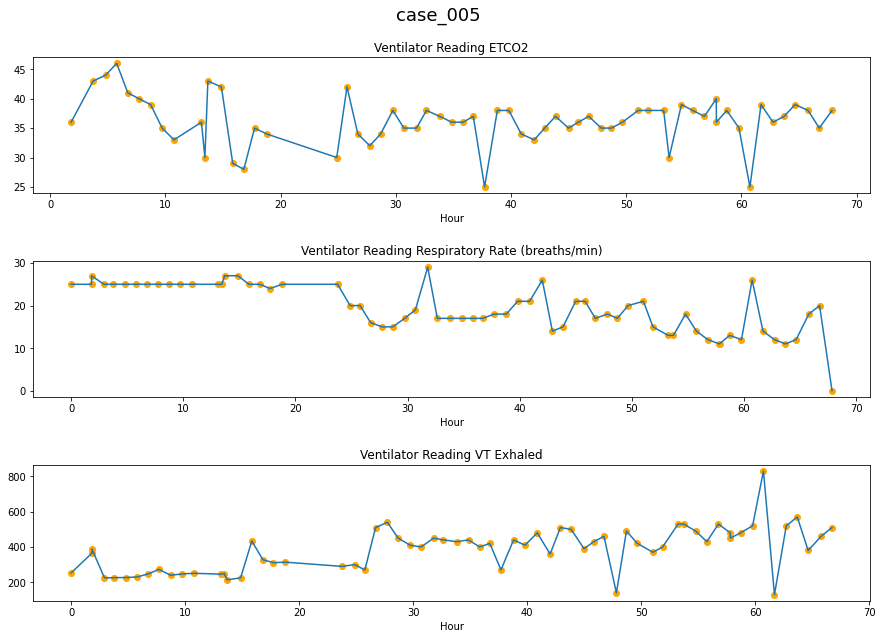

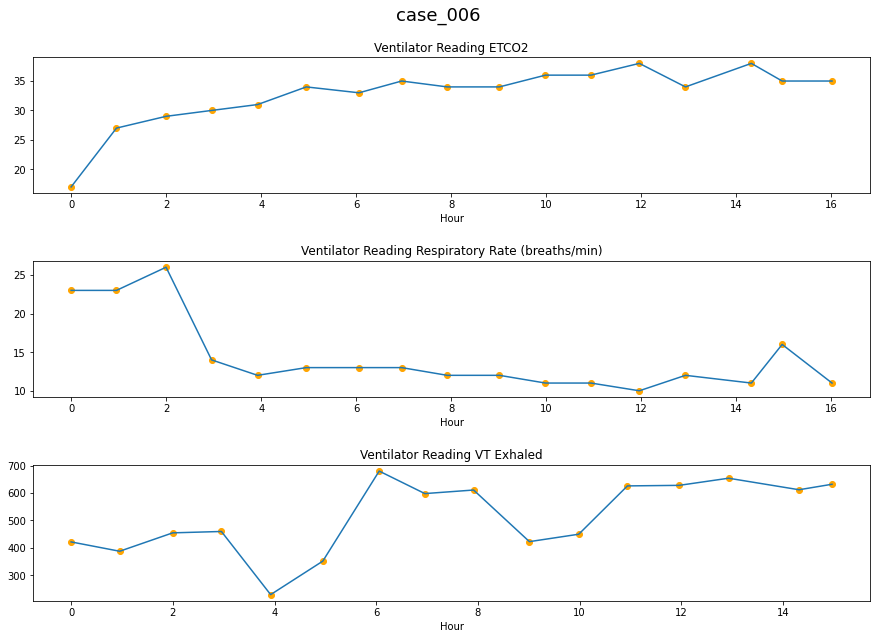

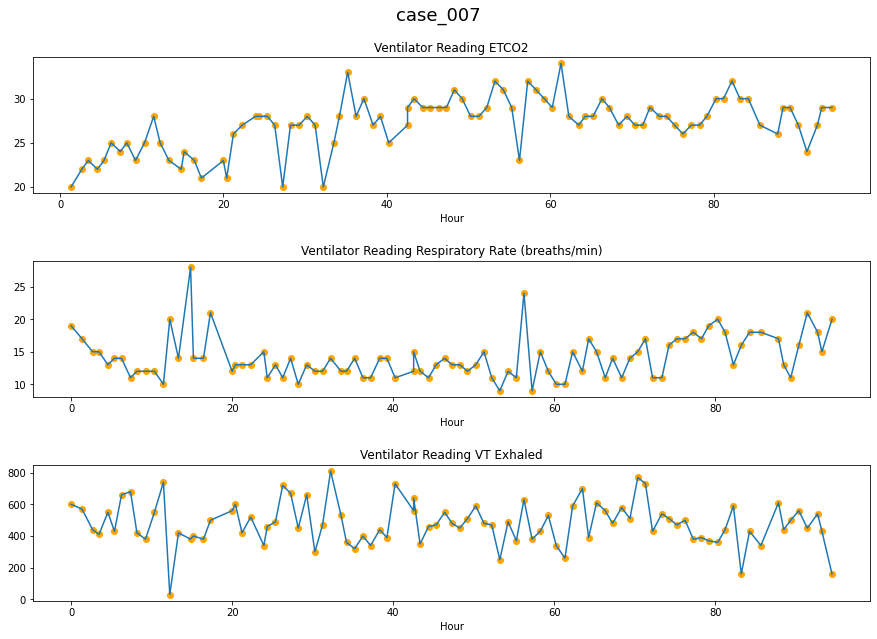

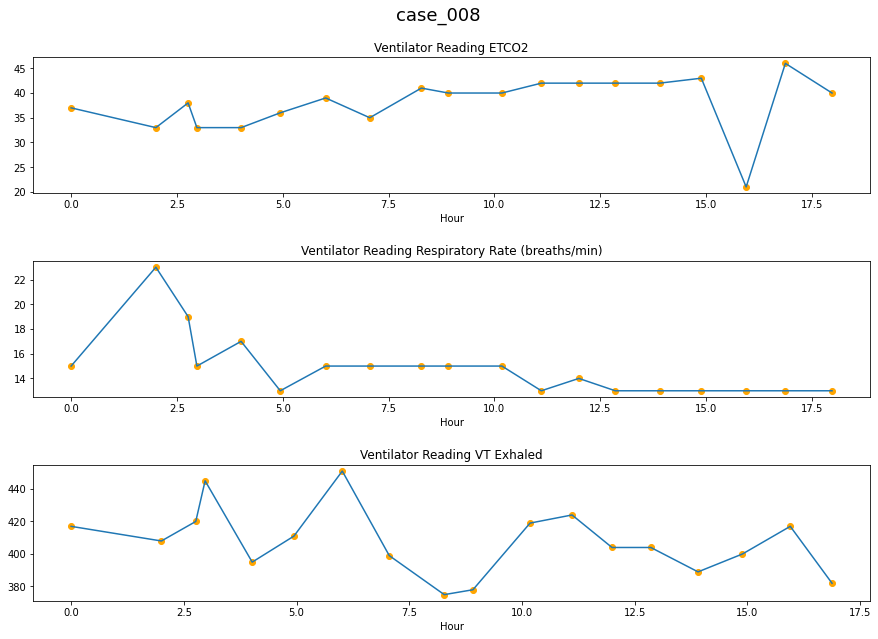

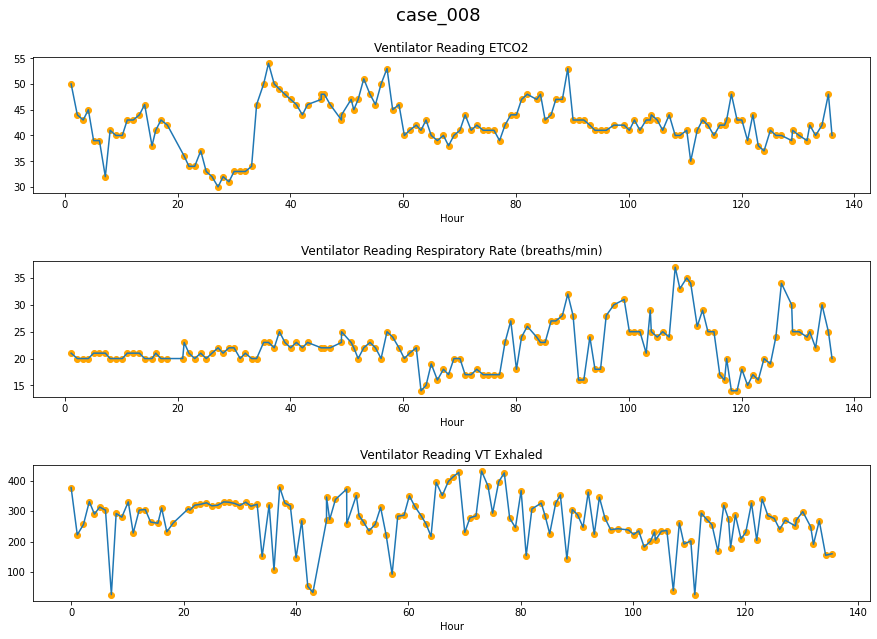

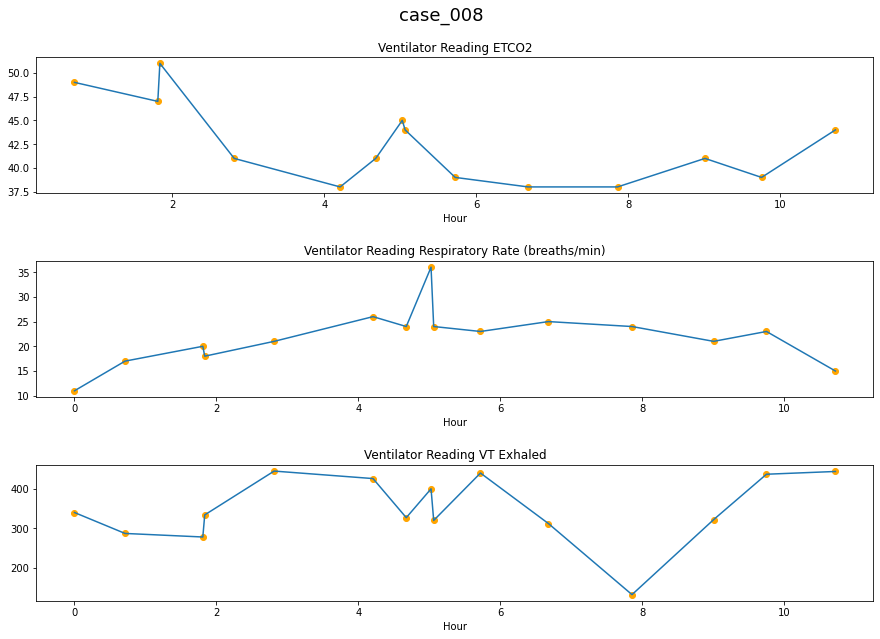

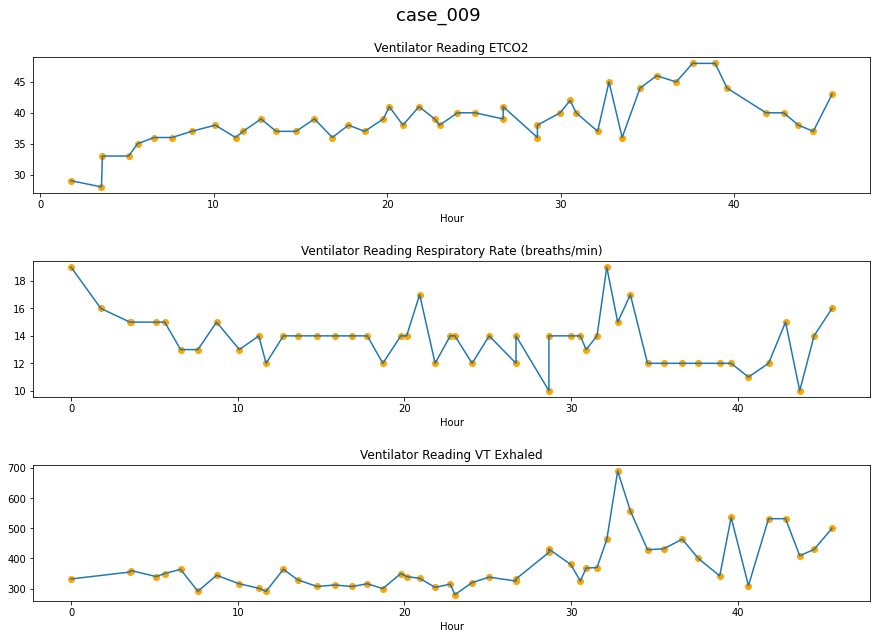

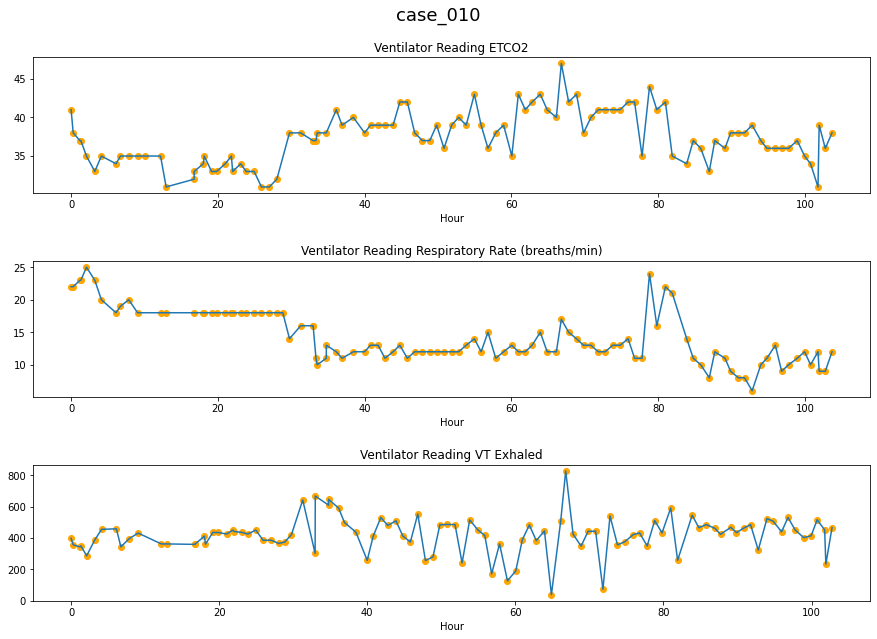

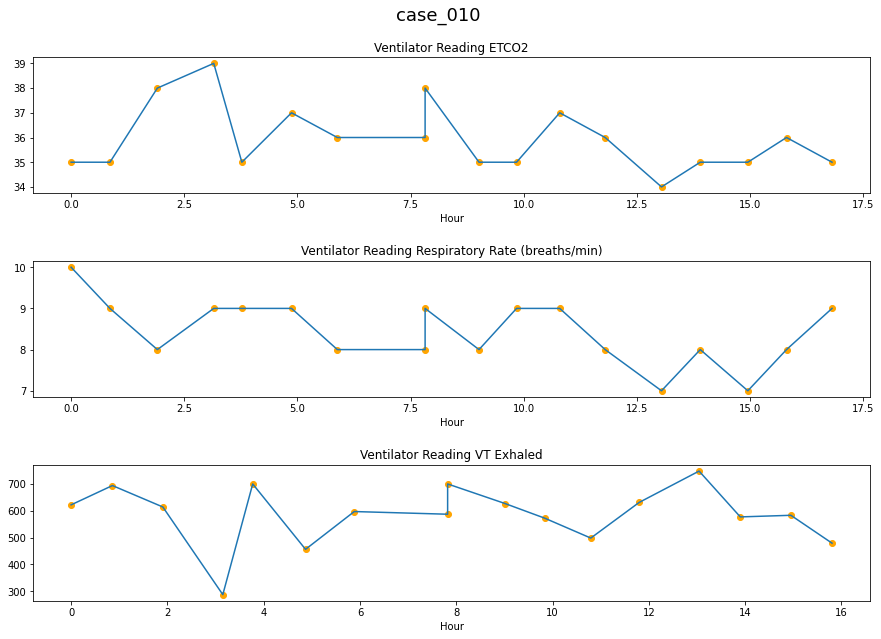

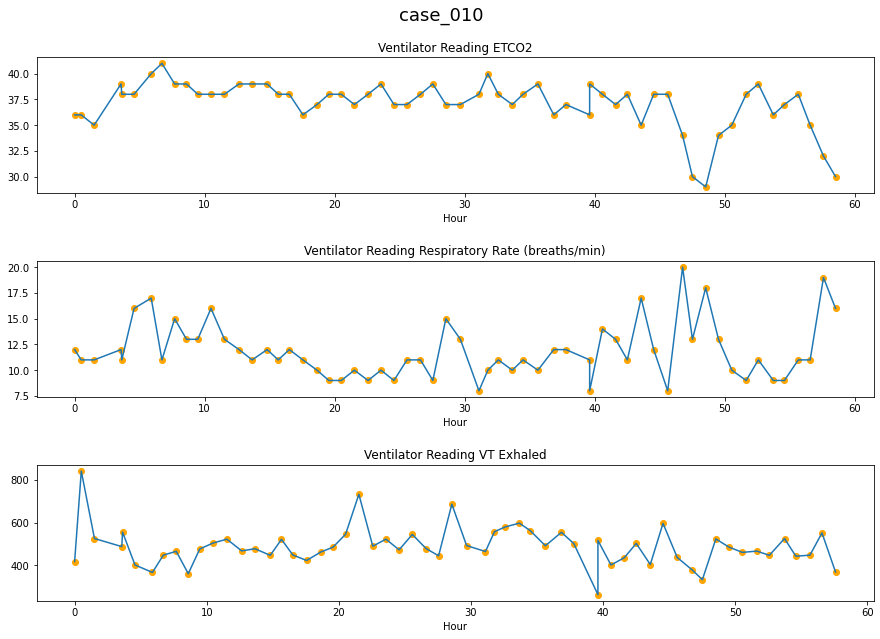

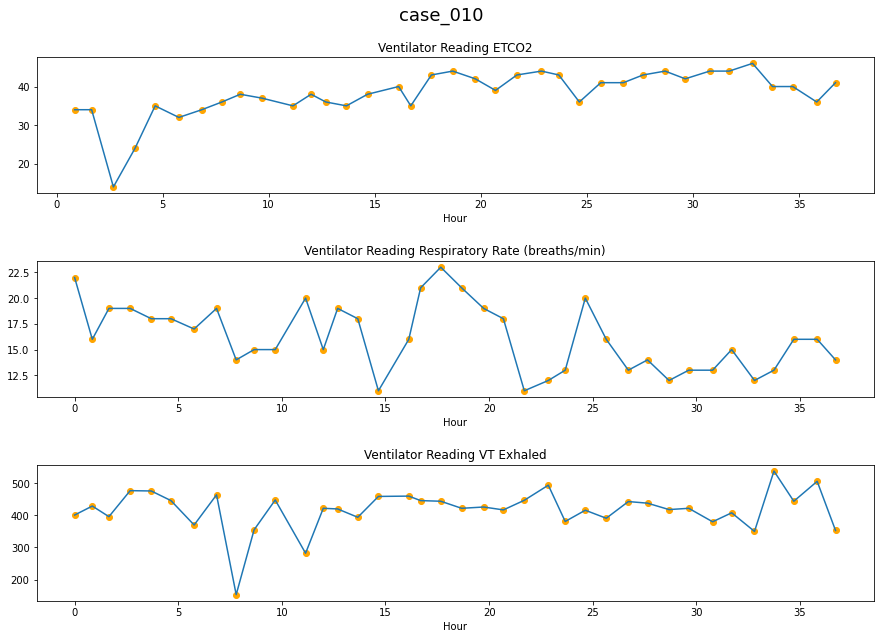

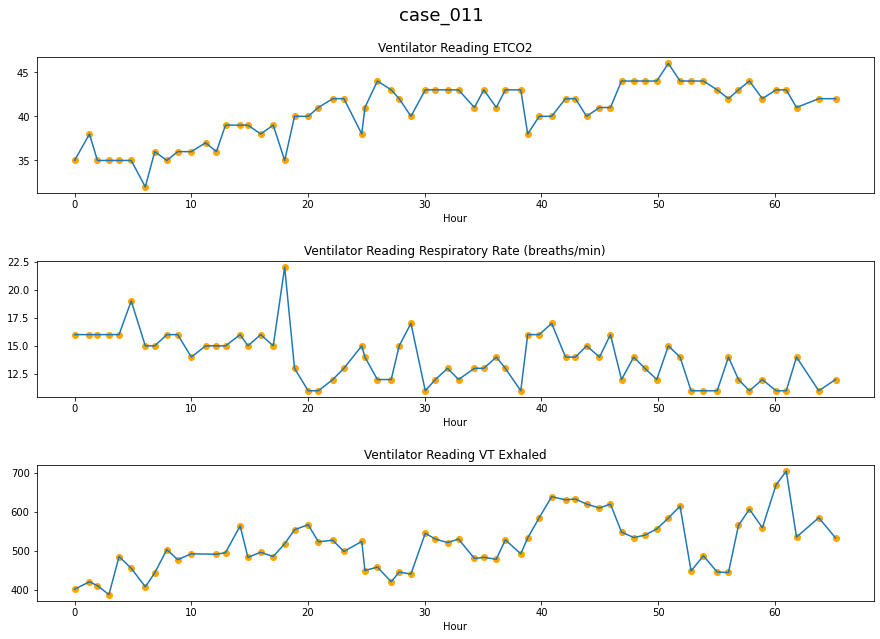

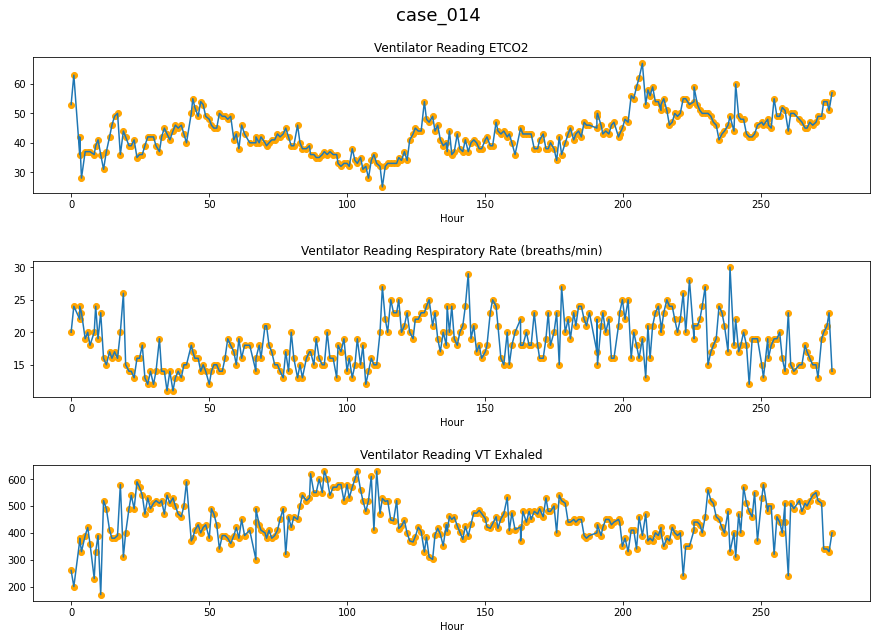

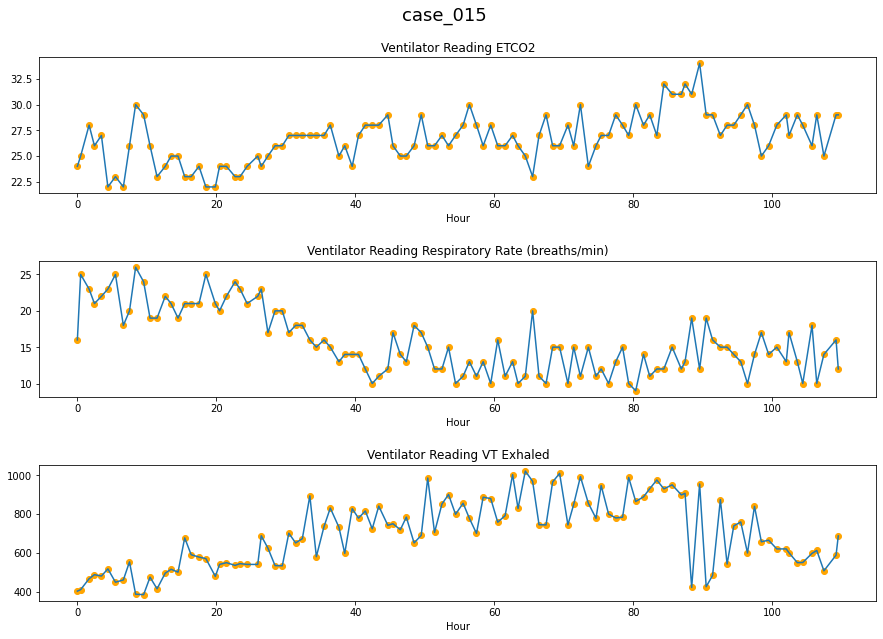

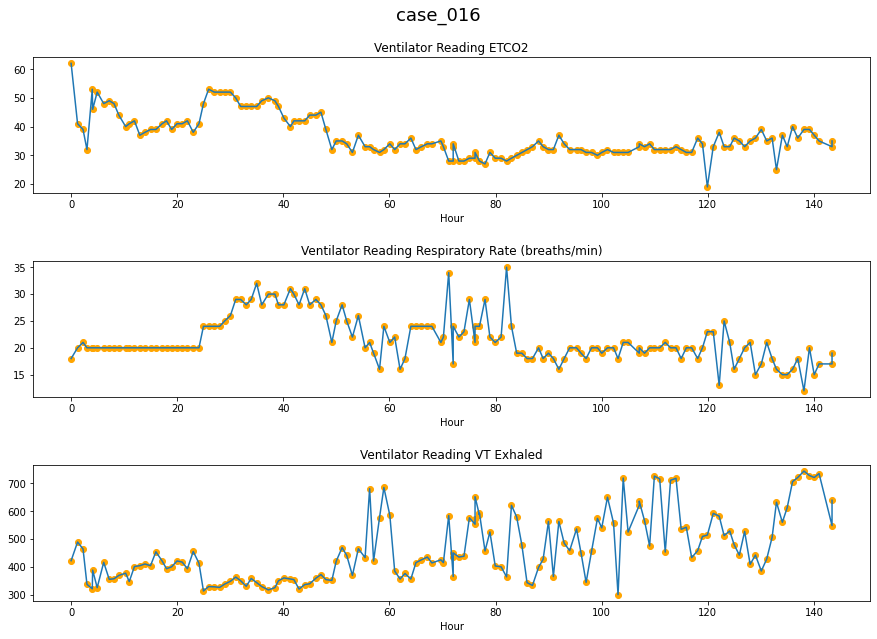

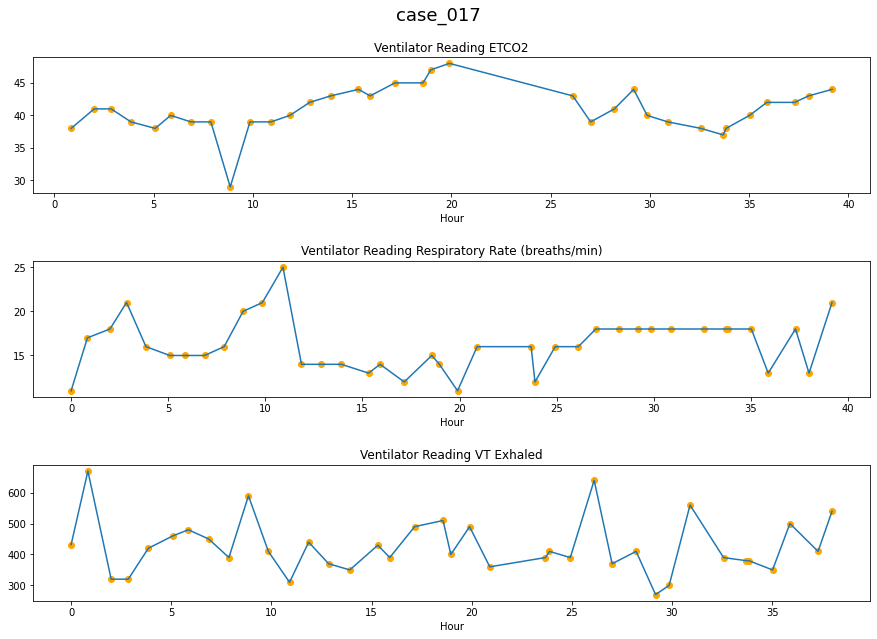

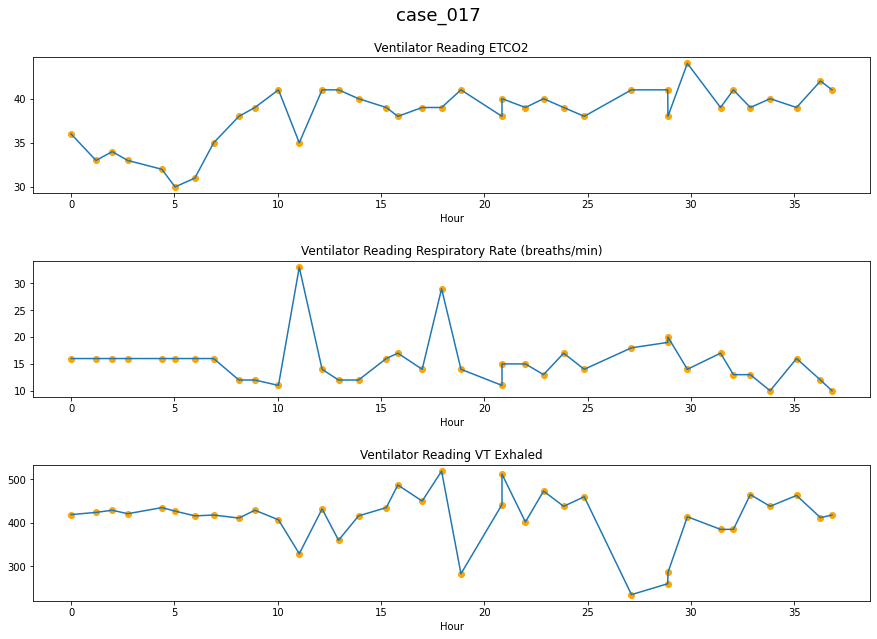

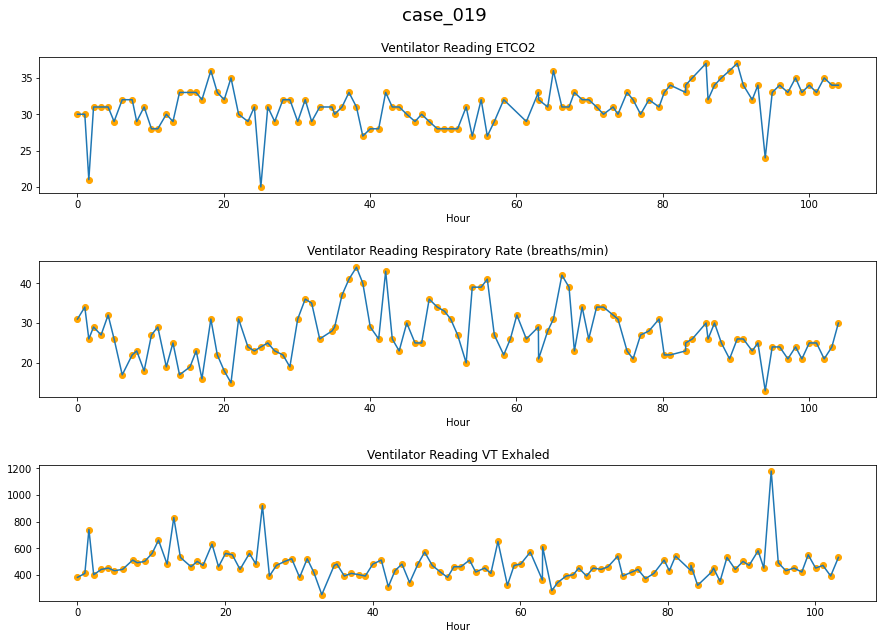

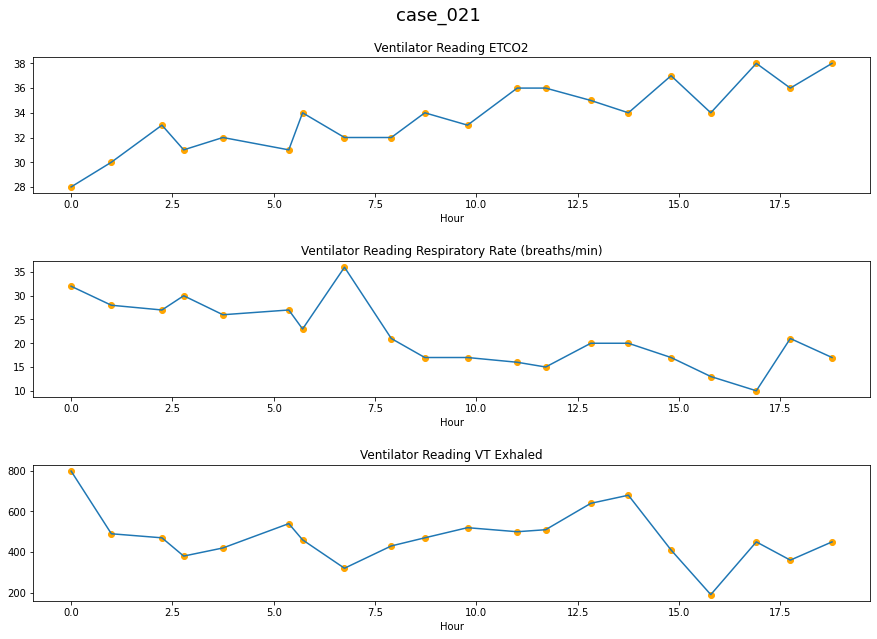

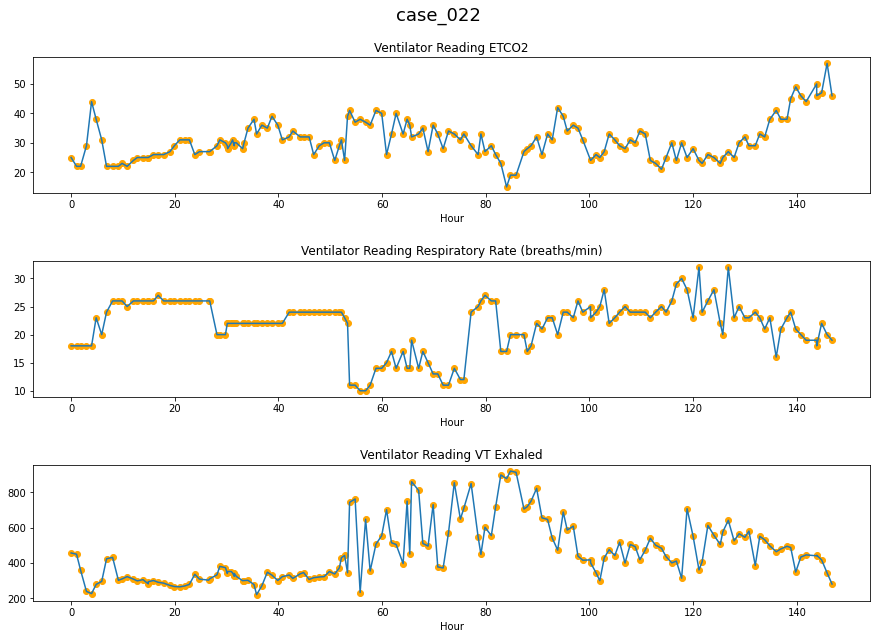

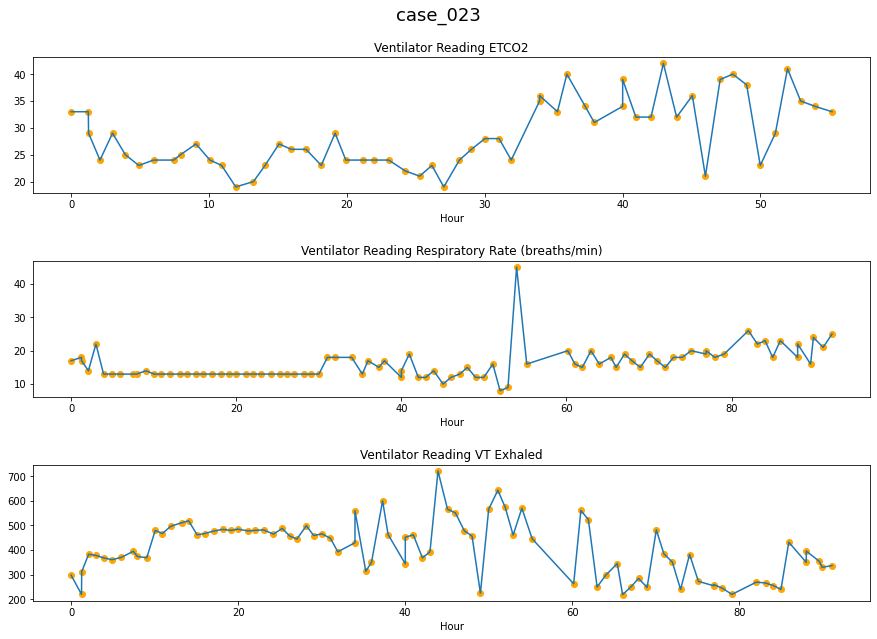

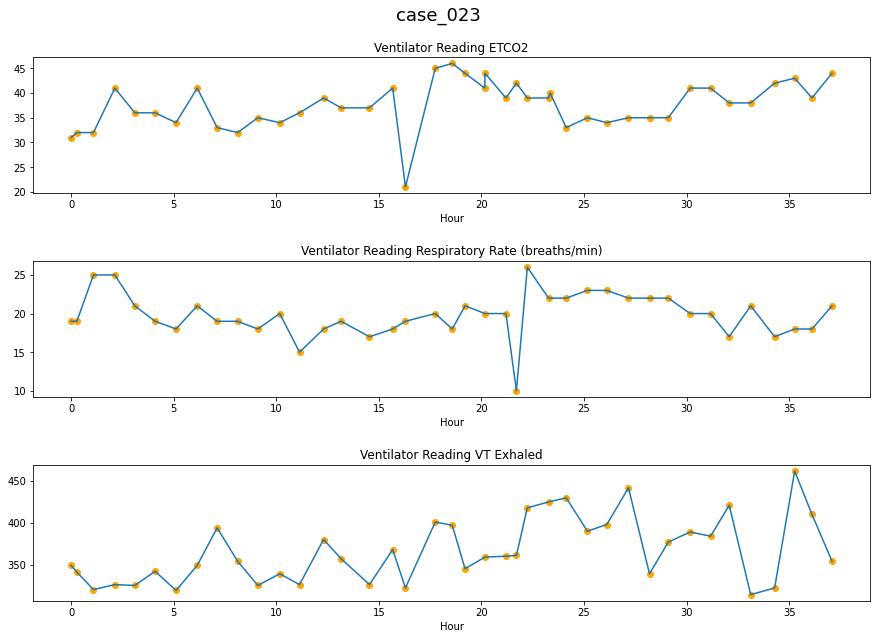

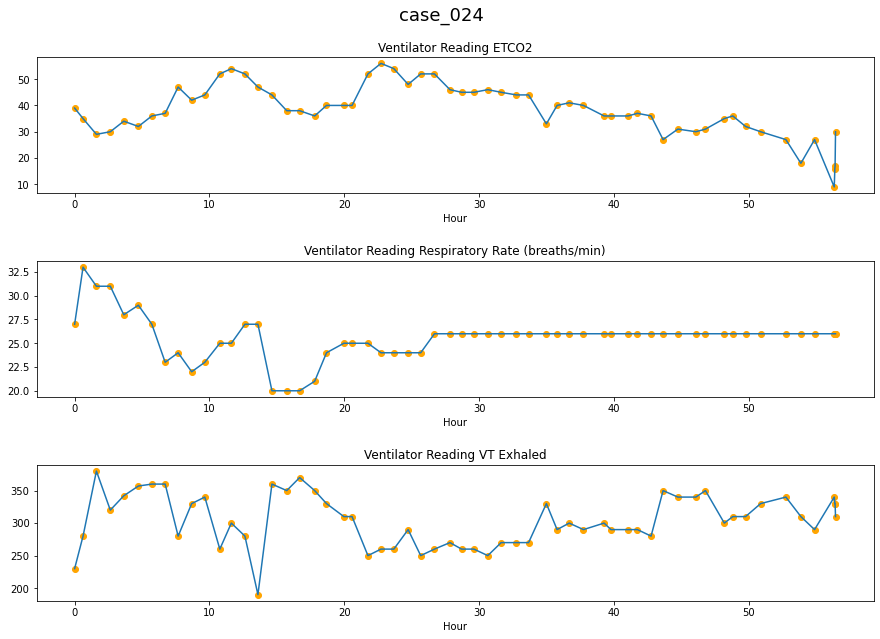

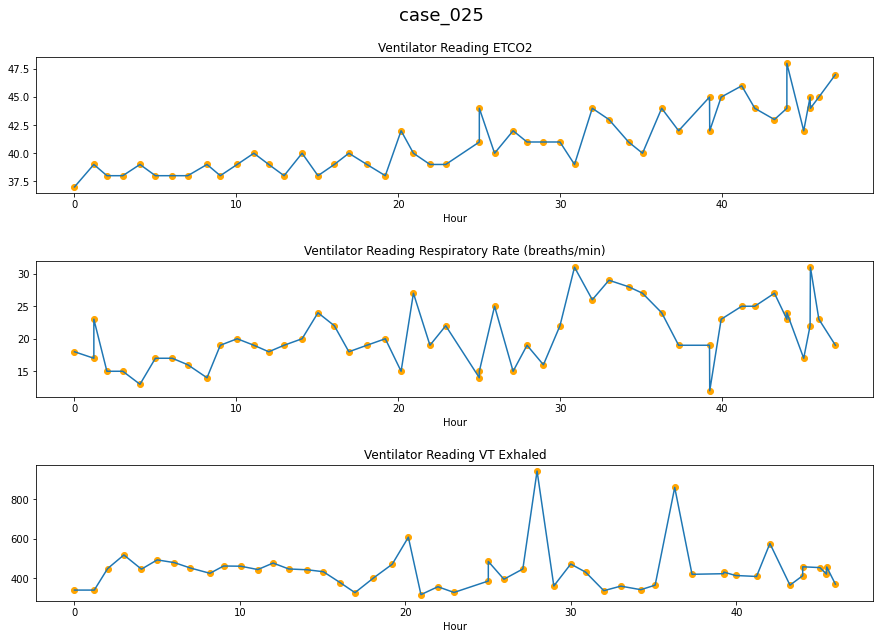

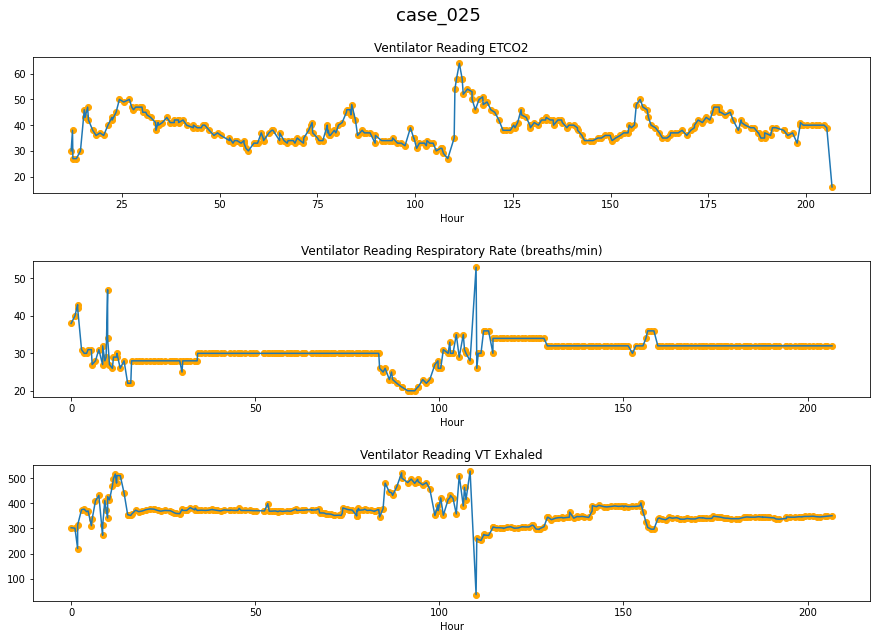

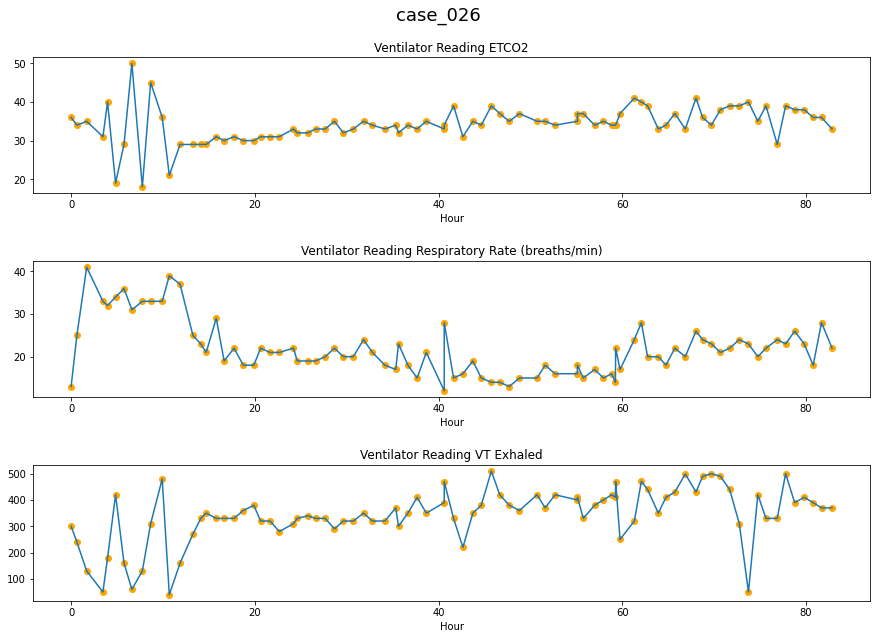

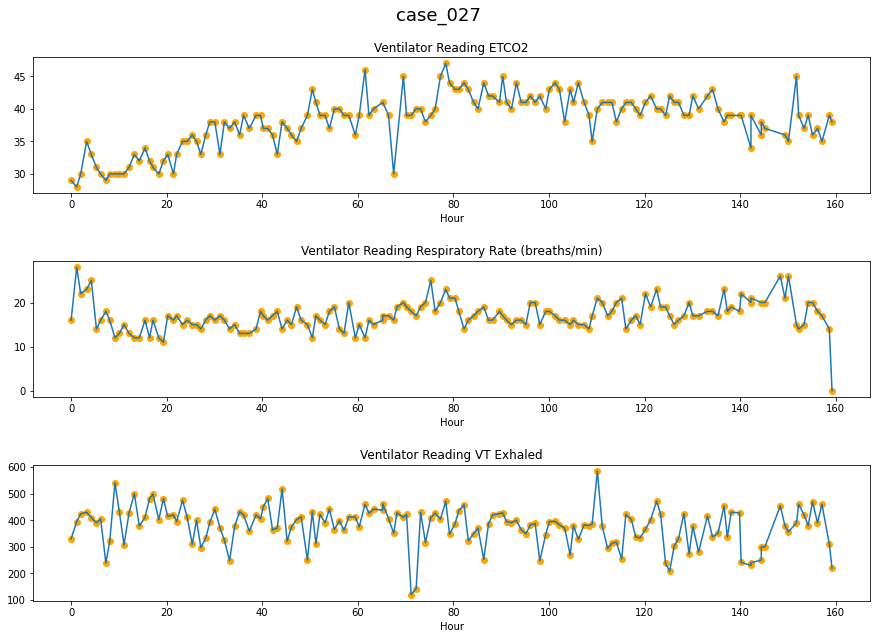

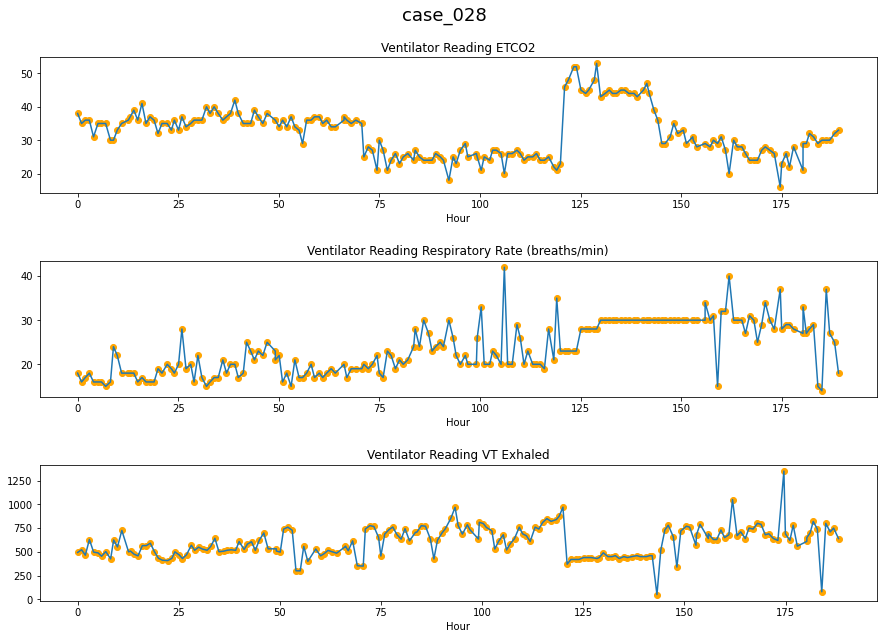

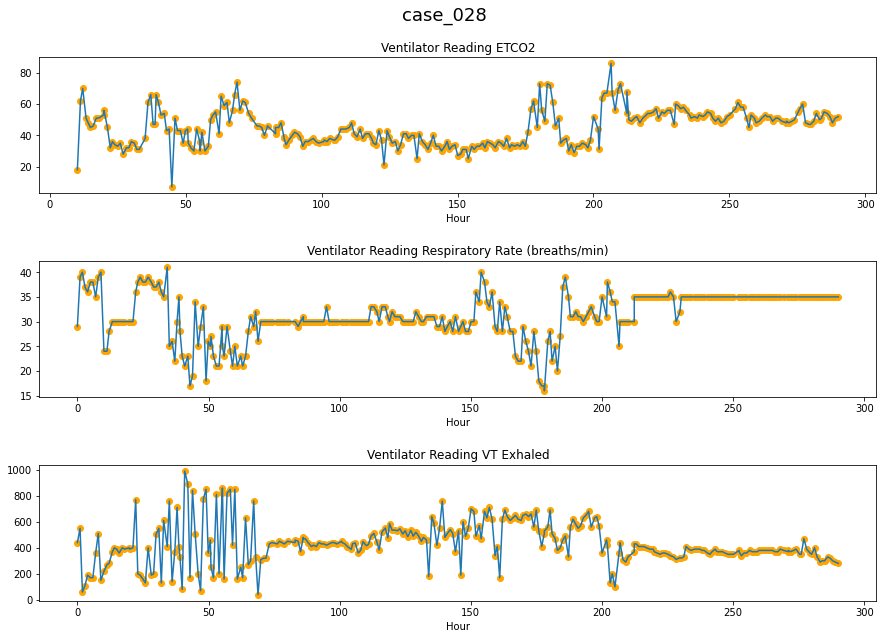

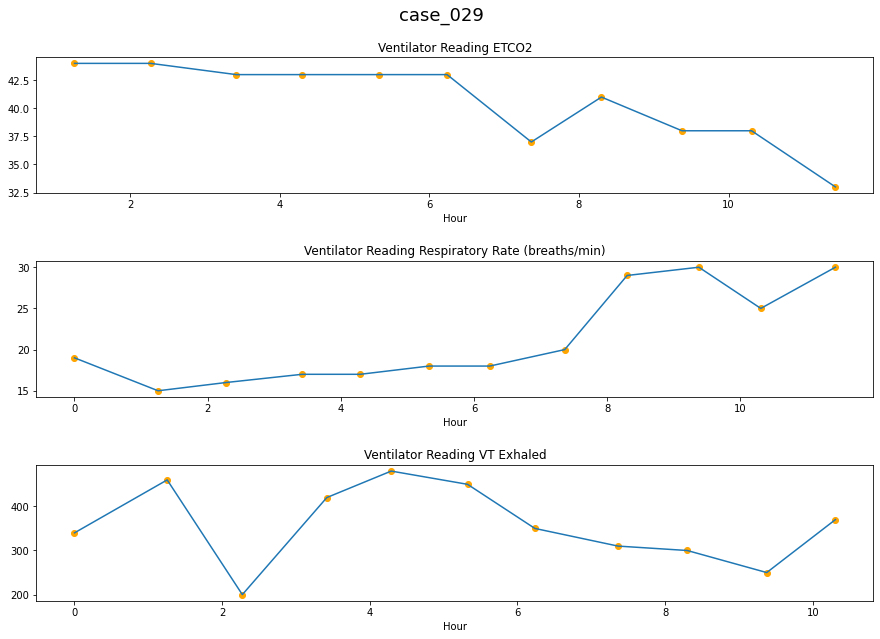

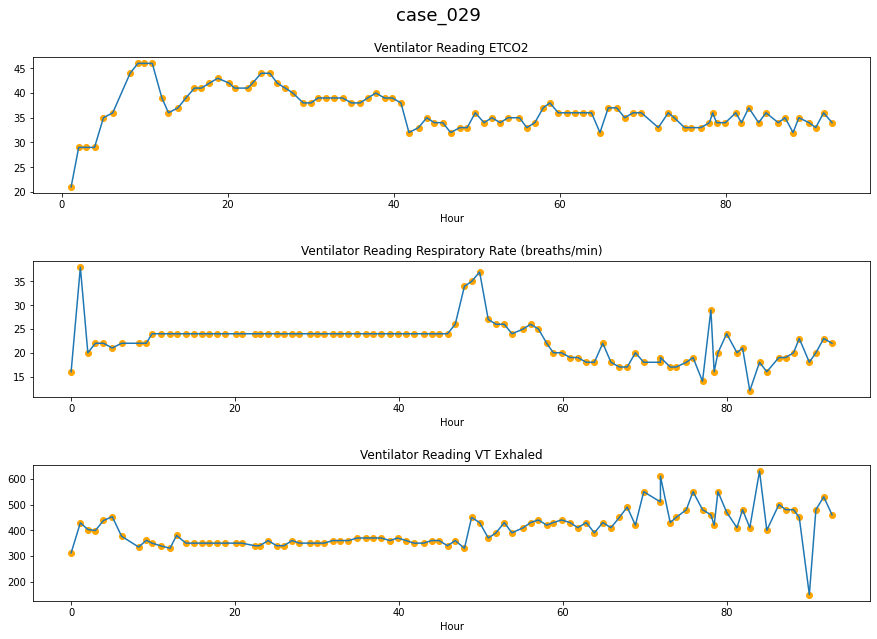

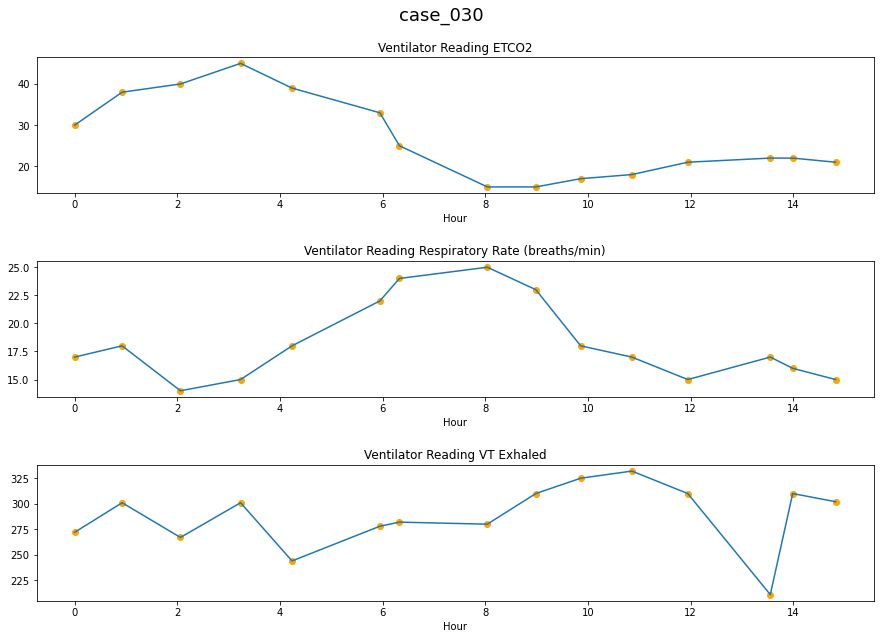

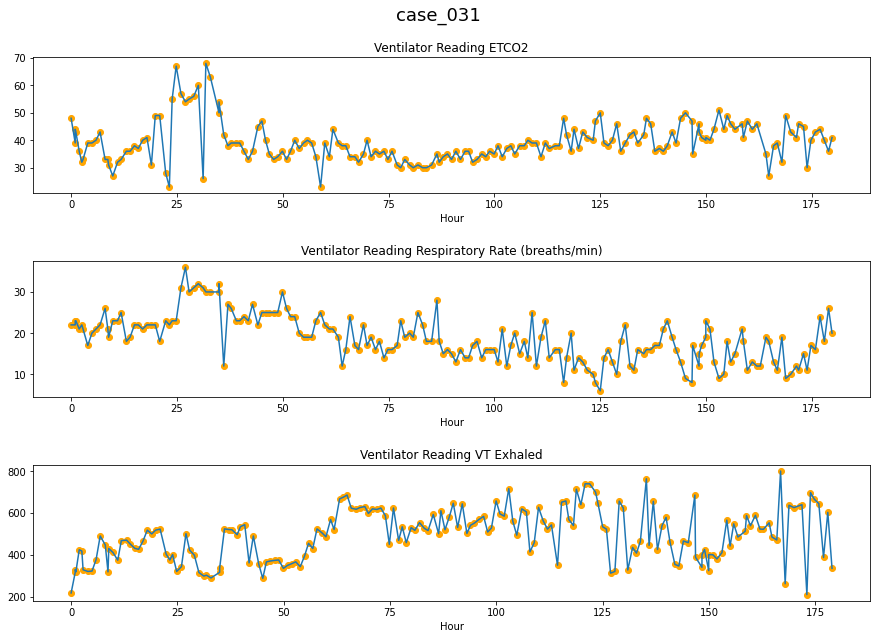

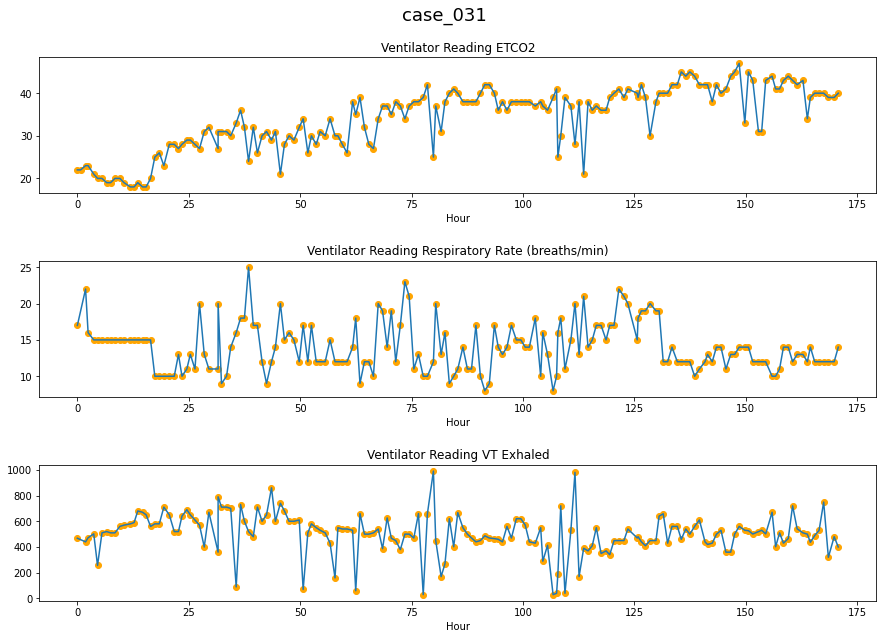

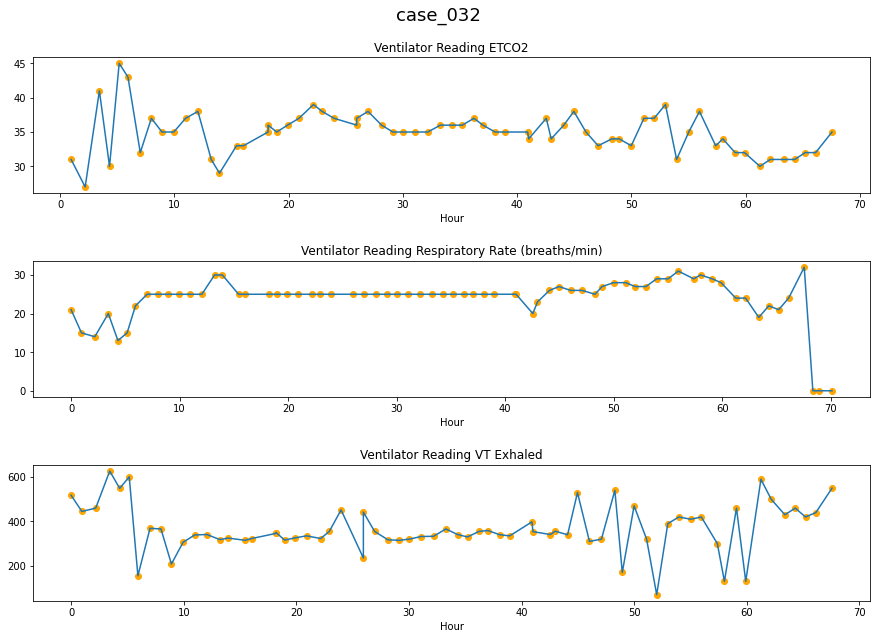

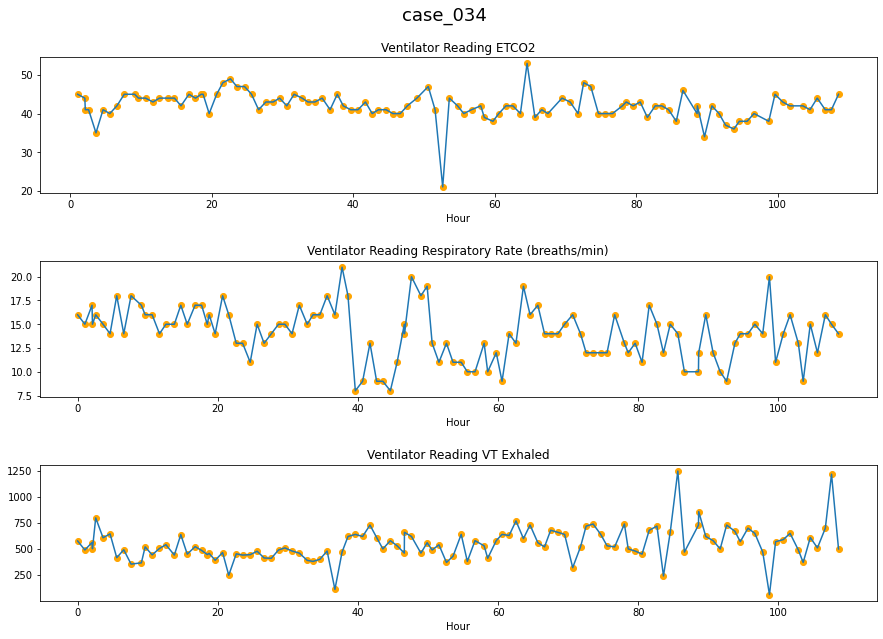

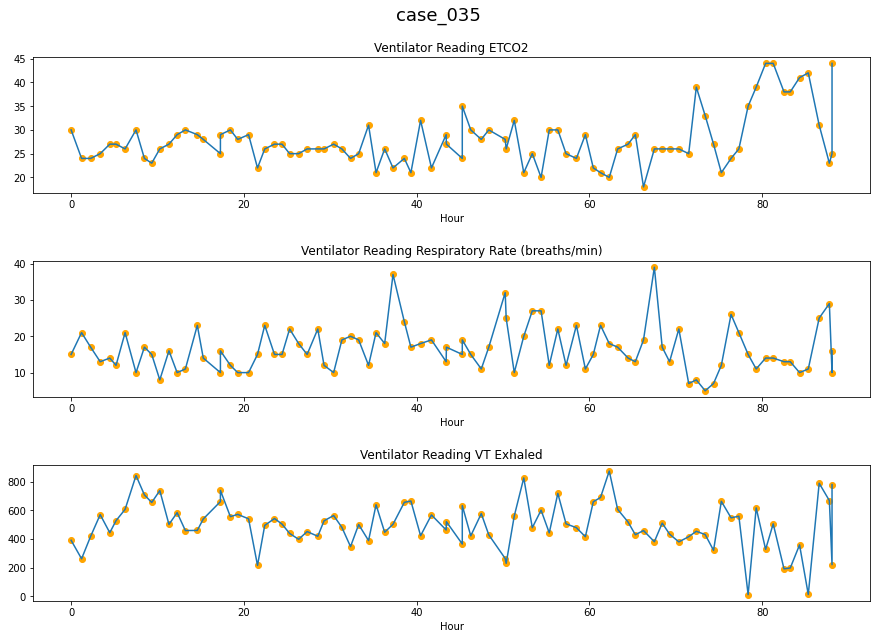

In [13]:
for i in range(len(df_list)):
    plot_indi_intubation(df_list[i])

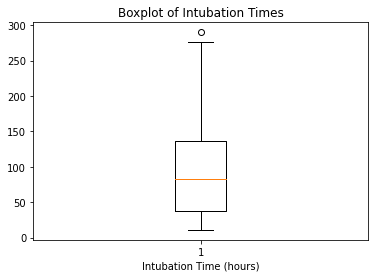

In [14]:
# Plot a boxplot of the intubation times
plt.boxplot(intubation_time_list)

# Add labels and title
plt.xlabel("Intubation Time (hours)")
plt.title("Boxplot of Intubation Times")

# Show the plot
plt.show()

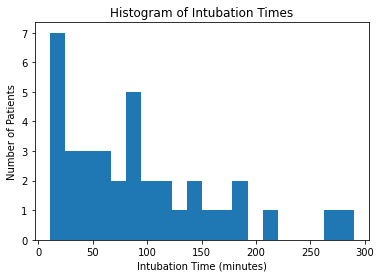

In [15]:
# Plot a histogram of the intubation times
plt.hist(intubation_time_list, bins=20)

# Add labels and title
plt.xlabel("Intubation Time (minutes)")
plt.ylabel("Number of Patients")
plt.title("Histogram of Intubation Times")

# Show the plot
plt.show()

# 4. Train/Test Set Split

In [105]:
import random
from sklearn.model_selection import GroupShuffleSplit
def split_train_test_by_case(df_list, intubation_time_list, test_size=0.3):
    case_numbers = []
    for df in df_list:
        case_numbers.append(df['Case Number'].unique()[0])
    
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=16)
    train_index, test_index = next(gss.split(df_list, intubation_time_list, groups=case_numbers))
    
    train_df_list = [df_list[i] for i in train_index]
    train_intubation_time_list = [intubation_time_list[i] for i in train_index]
    test_df_list = [df_list[i] for i in test_index]
    test_intubation_time_list = [intubation_time_list[i] for i in test_index]
    
    return train_df_list, train_intubation_time_list, test_df_list, test_intubation_time_list

train_df_list, train_intubation_time_list, test_df_list, test_intubation_time_list = split_train_test_by_case(df_list, intubation_time_list)


# 5. Sliding Window

In [106]:
import numpy as np

def sliding_window(df_list, intubation_time_list, window_size, step_size):
    input_list = []
    label_list = []
    for df, time in zip(df_list, intubation_time_list):
        if len(df) < window_size:
            continue
        etco2 = df[df['Item Description'] == 'Ventilator Reading ETCO2']['Value Text'].values
        breathrate = df[df['Item Description'] == 'Ventilator Reading Respiratory Rate (breaths/min)']['Value Text'].values
        vt_exhaled = df[df['Item Description'] == 'Ventilator Reading VT Exhaled']['Value Text'].values
        min_length = min(len(etco2), len(breathrate), len(vt_exhaled))
        etco2 = etco2[:min_length]
        breathrate = breathrate[:min_length]
        vt_exhaled = vt_exhaled[:min_length]
        for i in range(0, len(etco2) - window_size + 1, step_size):
            window_etco2 = etco2[i:i+window_size]
            window_breathrate = breathrate[i:i+window_size]
            window_vt_exhaled = vt_exhaled[i:i+window_size]
            input_list.append(np.column_stack((window_etco2, window_breathrate, window_vt_exhaled)))
            label_list.append(time)

    return np.array(input_list, dtype=np.float32), np.array(label_list, dtype=np.float32)

trainX, trainy = sliding_window(train_df_list, train_intubation_time_list, window_size=60, step_size=1)
testX, testy = sliding_window(test_df_list, test_intubation_time_list, window_size=60, step_size=1)

In [107]:
trainX = np.array(trainX, dtype=np.float32)
trainy = np.array(trainy, dtype=np.float32)
testX = np.array(testX, dtype=np.float32)
testy = np.array(testy, dtype=np.float32)

In [108]:
print(trainX.shape)
print(trainy.shape)
print(testX.shape)
print(testy.shape)

(946, 60, 3)
(946,)
(759, 60, 3)
(759,)


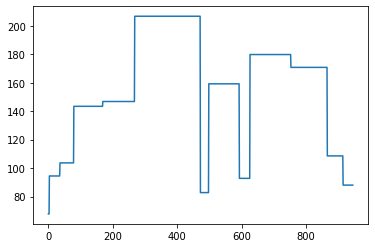

In [109]:
plt.plot(trainy)

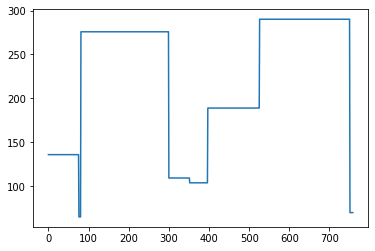

In [110]:
plt.plot(testy)

# Baseline Model: Mean Value of Training Set

In [109]:
def mean_value_baseline(trainX,trainy, testX, testy):
    mean_prediction = np.mean(trainy)
    mean_prediction = np.ones(len(testy)) * mean_prediction
    mae = np.mean(np.abs(testy - mean_prediction))
    return mae

mean_value_baseline_mae = mean_value_baseline(trainX, trainy, testX, testy)
print("Mean Value of Training Set MAE:", mean_value_baseline_mae)
    

Mean Value of Training Set MAE: 48.304902772141126


In [111]:
    mean_prediction = np.mean(trainy)
    mean_prediction = np.ones(len(testy)) * mean_prediction
    mae = np.mean(np.abs(testy - mean_prediction))

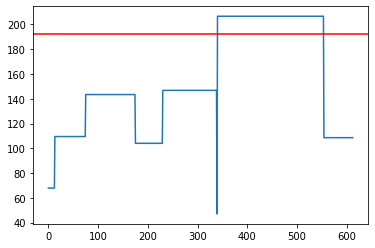

In [122]:
plt.plot(testy)
plt.axhline(y = 192, color = 'r', linestyle = '-')
plt.show()

In [532]:
def median_value_baseline(trainX,trainy, testX, testy):
    median_prediction = np.median(trainy)
    median_prediction = np.ones(len(testy)) * median_prediction
    mae = np.mean(np.abs(testy - median_prediction))
    return mae

median_value_baseline_mae = median_value_baseline(trainX, trainy, testX, testy)
print("Median Value of Training Set MAE:", median_value_baseline_mae)
    

Median Value of Training Set MAE: 93.82190755855314


# Baseline Model: Decision Tree Regressor

In [533]:
def decision_tree_regressor_baseline(trainX,trainy, testX, testy):
    
    trainX_2d = trainX.reshape(trainX.shape[0], -1)
    testX_2d = testX.reshape(testX.shape[0], -1)

    # Initialize the model
    regressor = DecisionTreeRegressor()

    # Fit the model to the training data
    regressor.fit(trainX_2d, trainy)

    # Predict the values for the test data
    y_pred = regressor.predict(testX_2d)


    # Evaluate the model
    mae = mean_absolute_error(testy, y_pred)
    
    return mae

dtr_mae = decision_tree_regressor_baseline(trainX,trainy, testX, testy)
print("Decision Tree Regressor MAE:", dtr_mae)


Decision Tree Regressor MAE: 81.63918427618516


# Model Experiment: LSTM

In [ ]:
def train_and_evaluate_lstm(trainX, trainy, testX, testy):
    input_shape = (trainX.shape[1], trainX.shape[2])
    model = Sequential()
    #model.add(BatchNormalization())
    #model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    #model.add(LayerNormalization())
    #model.add(Dropout(0.5))
    model.add(LSTM(128, input_shape=input_shape))
    #model.add(LayerNormalization())
    #model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae', optimizer='adam')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
    model.fit(trainX, trainy, epochs=100, batch_size=64, validation_data=(testX, testy), callbacks=[early_stop, reduce_lr])
    
    y_pred = model.predict(testX)
    mae = mean_absolute_error(y_pred, testy)
    return mae, y_pred

lstm_mae, pred_y = train_and_evaluate_lstm(trainX, trainy, testX, testy)
print('LSTM MAE:', lstm_mae)

# Model Experiment: CNN

In [120]:
def train_and_evaluate_cnn(trainX, trainy, testX, testy):  
    input_shape = (trainX.shape[1], trainX.shape[2])
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    #model.add(Conv1D(64, kernel_size=3, activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae', optimizer='adam')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
    model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, batch_size=32, callbacks=[early_stop, lr_scheduler])
    
    y_pred = model.predict(testX)
    mae = mean_absolute_error(y_pred, testy)
    
    return mae,y_pred

cnn_mae,y_pred = train_and_evaluate_cnn(trainX, trainy, testX, testy)
print('CNN MAE:', cnn_mae)



Epoch 1/100
30/30 [==============================] - 1s 12ms/step - loss: 69.5380 - val_loss: 98.7019 - lr: 0.0010
Epoch 2/100
30/30 [==============================] - 0s 8ms/step - loss: 48.2249 - val_loss: 87.9632 - lr: 0.0010
Epoch 3/100
30/30 [==============================] - 0s 7ms/step - loss: 43.6185 - val_loss: 82.8856 - lr: 0.0010
Epoch 4/100
30/30 [==============================] - 0s 7ms/step - loss: 43.6912 - val_loss: 89.5653 - lr: 0.0010
Epoch 5/100
30/30 [==============================] - 0s 7ms/step - loss: 45.2288 - val_loss: 88.7921 - lr: 0.0010
Epoch 6/100
30/30 [==============================] - 0s 7ms/step - loss: 43.4686 - val_loss: 76.2730 - lr: 0.0010
Epoch 7/100
30/30 [==============================] - 0s 7ms/step - loss: 43.6490 - val_loss: 64.9639 - lr: 0.0010
Epoch 8/100
30/30 [==============================] - 0s 7ms/step - loss: 40.9280 - val_loss: 71.6769 - lr: 0.0010
Epoch 9/100
30/30 [==============================] - 0s 7ms/step - loss: 41.0078 - val_

In [118]:
input_shape

(60, 3)

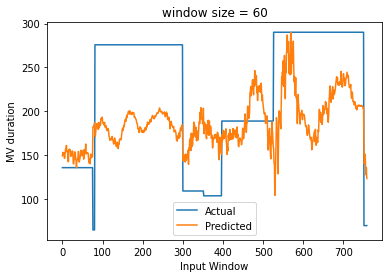

In [121]:
plt.plot(testy, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Input Window')
plt.ylabel('MV duration')
plt.title('window size = 60')
plt.legend()
plt.show()

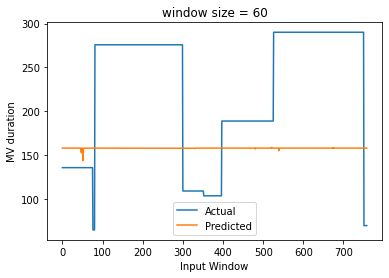

In [123]:
plt.plot(testy, label='Actual')
plt.plot(pred_y, label='Predicted')
plt.xlabel('Input Window')
plt.ylabel('MV duration')
plt.title('window size = 60')
plt.legend()
plt.show()

# Model Experiment: TCN

In [93]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from tcn import TCN

def build_tcn_model(input_shape):
    i = Input(shape=input_shape)
    o = TCN(nb_filters=64,
            kernel_size=3,
            nb_stacks=1,
            dilations=[1, 2, 4, 8, 16, 32, 64, 128, 256],
            padding='causal',
            use_skip_connections=True)(i)
    o = Dense(units=1, activation='linear')(o)
    model = Model(inputs=[i], outputs=[o])
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model

def train_and_evaluate_tcn(trainX, trainy, testX, testy):  
    input_shape = (trainX.shape[1], trainX.shape[2])
    model = build_tcn_model(input_shape)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
    model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, batch_size=32, callbacks=[early_stop, lr_scheduler])

    y_pred = model.predict(testX)
    mae = mean_absolute_error(y_pred, testy)
    return mae, y_pred

tcn_mae, y_pred = train_and_evaluate_tcn(trainX, trainy, testX, testy)
print('TCN MAE:', tcn_mae)


Epoch 1/100
37/37 [==============================] - 8s 142ms/step - loss: 883.1451 - val_loss: 134.8137 - lr: 0.0010
Epoch 2/100
37/37 [==============================] - 4s 118ms/step - loss: 75.5548 - val_loss: 68.3246 - lr: 0.0010
Epoch 3/100
37/37 [==============================] - 4s 118ms/step - loss: 68.0936 - val_loss: 42.4018 - lr: 0.0010
Epoch 4/100
37/37 [==============================] - 4s 119ms/step - loss: 57.1680 - val_loss: 42.5230 - lr: 0.0010
Epoch 5/100
37/37 [==============================] - 5s 127ms/step - loss: 46.2457 - val_loss: 88.9902 - lr: 0.0010
Epoch 6/100
37/37 [==============================] - 4s 118ms/step - loss: 54.1044 - val_loss: 83.1113 - lr: 0.0010
Epoch 7/100
37/37 [==============================] - 4s 119ms/step - loss: 54.0494 - val_loss: 74.3021 - lr: 0.0010
Epoch 8/100
36/37 [============================>.] - ETA: 0s - loss: 43.4745
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
37/37 [=========================

# Model Experiment: GRU

In [ ]:
def train_and_evaluate_gru(trainX, trainy, testX, testy):
    input_shape = (trainX.shape[1], trainX.shape[2])
    model = Sequential()
    model.add(GRU(units=32, input_shape=input_shape))
    model.add(Dense(units=1, activation='linear'))

    model.compile(loss='mean_absolute_error', optimizer='adam')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
    model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, batch_size=32, callbacks=[early_stop, lr_scheduler])
    y_pred = model.predict(testX)
    mae = mean_absolute_error(y_pred, testy)
    return mae

gru_mae = train_and_evaluate_gru(trainX, trainy, testX, testy)
print('GRU mae:', gru_mae)


In [84]:
def train_and_evaluate_cnn_lstm(trainX, trainy, testX, testy):
    input_shape = (trainX.shape[1], trainX.shape[2])
    
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae', optimizer='adam')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
    model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, batch_size=32, callbacks=[early_stop, lr_scheduler])
    
    y_pred = model.predict(testX)
    mae = mean_absolute_error(y_pred, testy)
    
    return mae, y_pred

cnn_lstm_mae, y_pred = train_and_evaluate_cnn_lstm(trainX, trainy, testX, testy)
print('CNN-LSTM MAE:', cnn_lstm_mae)


Epoch 1/100
37/37 [==============================] - 8s 64ms/step - loss: 164.3010 - val_loss: 153.0869 - lr: 0.0010
Epoch 2/100
37/37 [==============================] - 1s 39ms/step - loss: 136.3819 - val_loss: 150.0253 - lr: 0.0010
Epoch 3/100
37/37 [==============================] - 1s 37ms/step - loss: 123.2141 - val_loss: 146.3432 - lr: 0.0010
Epoch 4/100
37/37 [==============================] - 1s 39ms/step - loss: 110.7489 - val_loss: 109.8434 - lr: 0.0010
Epoch 5/100
37/37 [==============================] - 1s 33ms/step - loss: 101.1623 - val_loss: 114.1331 - lr: 0.0010
Epoch 6/100
37/37 [==============================] - 1s 38ms/step - loss: 97.3030 - val_loss: 53.5044 - lr: 0.0010
Epoch 7/100
37/37 [==============================] - 1s 32ms/step - loss: 90.7803 - val_loss: 80.5753 - lr: 0.0010
Epoch 8/100
37/37 [==============================] - 1s 37ms/step - loss: 92.4818 - val_loss: 55.0666 - lr: 0.0010
Epoch 9/100
37/37 [==============================] - 2s 42ms/step - lo

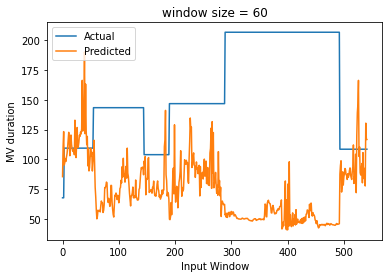

In [83]:
plt.plot(testy, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Input Window')
plt.ylabel('MV duration')
plt.title('window size = 60')
plt.legend()
plt.show()

# Cross Validation (5-fold)

In [470]:
# Cross Validation
import random
from sklearn.model_selection import GroupKFold

def split_train_test_by_case(df_list, intubation_time_list, n_splits=5):
    case_numbers = []
    for df in df_list:
        case_numbers.append(df['Case Number'].unique()[0])

    group_kfold = GroupKFold(n_splits=n_splits)

    split_data = []

    for train_index, test_index in group_kfold.split(df_list, intubation_time_list, groups=case_numbers):
        train_df_list = [df_list[i] for i in train_index]
        train_intubation_time_list = [intubation_time_list[i] for i in train_index]
        test_df_list = [df_list[i] for i in test_index]
        test_intubation_time_list = [intubation_time_list[i] for i in test_index]

        split_data.append((train_df_list, train_intubation_time_list, test_df_list, test_intubation_time_list))

    return split_data

# Define the models to test
models = {
    "mean_value_baseline": mean_value_baseline,
    "decision_tree_regressor_baseline": decision_tree_regressor_baseline,
    "lstm": train_and_evaluate_lstm,
    "cnn": train_and_evaluate_cnn,
    "tcn": train_and_evaluate_tcn,
    "gru": train_and_evaluate_gru
}

# Define the window size and step size for sliding window
window_size = 20
step_size = 1

# Perform cross-validation for each model
evaluation_metrics = {}
for model_name, model_func in models.items():
    print(f"Evaluating model: {model_name}")
    evaluation_metrics[model_name] = []
    
    for fold, (train_df_list, train_intubation_time_list, test_df_list, test_intubation_time_list) in enumerate(split_train_test_by_case(df_list, intubation_time_list)):
        print(f"Processing fold {fold + 1}")
        
        # Generate training and testing data
        trainX, trainy = sliding_window(train_df_list, train_intubation_time_list, window_size=window_size, step_size=step_size)
        testX, testy = sliding_window(test_df_list, test_intubation_time_list, window_size=window_size, step_size=step_size)
        trainX = np.array(trainX, dtype=np.float32)
        trainy = np.array(trainy, dtype=np.float32)
        testX = np.array(testX, dtype=np.float32)
        testy = np.array(testy, dtype=np.float32)
        # Train and evaluate the model on the current fold
        evaluation_metric = model_func(trainX, trainy, testX, testy)
        
        # Record the evaluation metric for the current fold
        evaluation_metrics[model_name].append(evaluation_metric)

# Calculate the average performance across all folds for each model
for model_name, metrics in evaluation_metrics.items():
    average_performance = sum(metrics) / len(metrics)
    print(f"Model {model_name} average performance across all folds: {average_performance}")


Evaluating model: mean_value_baseline
Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5
Evaluating model: decision_tree_regressor_baseline
Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5
Evaluating model: lstm
Processing fold 1
Epoch 1/100
33/33 [==============================] - 3s 35ms/step - loss: 154.8896 - val_loss: 172.1735 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 1s 17ms/step - loss: 150.4868 - val_loss: 164.4618 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 1s 19ms/step - loss: 139.1463 - val_loss: 152.4411 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 0s 14ms/step - loss: 127.9719 - val_loss: 141.6680 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 0s 15ms/step - loss: 117.2358 - val_loss: 130.9926 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 1s 15ms/step - loss: 106.7361 - val_loss: 120.0526 -

Epoch 23/100
33/33 [==============================] - 1s 16ms/step - loss: 68.3831 - val_loss: 53.5274 - lr: 0.0010
Epoch 24/100
33/33 [==============================] - 1s 20ms/step - loss: 68.6953 - val_loss: 53.5703 - lr: 0.0010
Epoch 25/100
33/33 [==============================] - 1s 16ms/step - loss: 67.5964 - val_loss: 55.7205 - lr: 0.0010
Epoch 26/100
31/33 [===========================>..] - ETA: 0s - loss: 64.8032Restoring model weights from the end of the best epoch: 21.

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
33/33 [==============================] - 0s 15ms/step - loss: 64.7316 - val_loss: 61.0195 - lr: 0.0010
Epoch 26: early stopping
23/23 [==============================] - 1s 4ms/step
Processing fold 4
Epoch 1/100
38/38 [==============================] - 4s 30ms/step - loss: 167.5341 - val_loss: 111.6028 - lr: 0.0010
Epoch 2/100
38/38 [==============================] - 1s 16ms/step - loss: 163.5282 - val_loss: 109.7024 - lr: 0.0010
Epo

65/65 [==============================] - 0s 7ms/step - loss: 48.7076 - val_loss: 65.6516 - lr: 0.0010
Epoch 13/100
65/65 [==============================] - 0s 7ms/step - loss: 46.4351 - val_loss: 65.8266 - lr: 1.0000e-04
Epoch 14/100
65/65 [==============================] - 0s 7ms/step - loss: 47.3355 - val_loss: 66.9542 - lr: 1.0000e-04
Epoch 15/100
65/65 [==============================] - 1s 10ms/step - loss: 47.0726 - val_loss: 66.5096 - lr: 1.0000e-04
Epoch 16/100
65/65 [==============================] - 1s 8ms/step - loss: 47.5521 - val_loss: 66.1592 - lr: 1.0000e-04
Epoch 17/100
63/65 [============================>.] - ETA: 0s - loss: 47.6054Restoring model weights from the end of the best epoch: 7.

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
65/65 [==============================] - 1s 9ms/step - loss: 47.5483 - val_loss: 67.6806 - lr: 1.0000e-04
Epoch 17: early stopping
23/23 [==============================] - 0s 3ms/step
Processing fold 2
Epoc

Epoch 6/100
69/69 [==============================] - 0s 7ms/step - loss: 49.4675 - val_loss: 87.9888 - lr: 0.0010
Epoch 7/100
69/69 [==============================] - ETA: 0s - loss: 47.8026
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 1s 8ms/step - loss: 47.8026 - val_loss: 86.7302 - lr: 0.0010
Epoch 8/100
69/69 [==============================] - 1s 8ms/step - loss: 47.0774 - val_loss: 86.7433 - lr: 1.0000e-04
Epoch 9/100
69/69 [==============================] - 1s 8ms/step - loss: 46.2217 - val_loss: 87.4628 - lr: 1.0000e-04
Epoch 10/100
69/69 [==============================] - 1s 9ms/step - loss: 47.1451 - val_loss: 87.9069 - lr: 1.0000e-04
Epoch 11/100
69/69 [==============================] - 0s 7ms/step - loss: 47.2257 - val_loss: 85.8225 - lr: 1.0000e-04
Epoch 12/100
69/69 [==============================] - ETA: 0s - loss: 46.4952Restoring model weights from the end of the best epoch: 2.

Epoch 12: ReduceLRO

Epoch 13/100
65/65 [==============================] - 8s 118ms/step - loss: 60.6950 - val_loss: 35.5727 - lr: 0.0010
Epoch 14/100
65/65 [==============================] - 7s 111ms/step - loss: 61.8973 - val_loss: 40.1641 - lr: 0.0010
Epoch 15/100
65/65 [==============================] - 7s 116ms/step - loss: 62.0622 - val_loss: 40.8440 - lr: 0.0010
Epoch 16/100
65/65 [==============================] - 8s 119ms/step - loss: 60.1467 - val_loss: 44.6367 - lr: 0.0010
Epoch 17/100
65/65 [==============================] - 7s 111ms/step - loss: 58.9205 - val_loss: 32.3551 - lr: 0.0010
Epoch 18/100
65/65 [==============================] - 8s 117ms/step - loss: 60.7034 - val_loss: 32.2488 - lr: 0.0010
Epoch 19/100
65/65 [==============================] - 8s 117ms/step - loss: 62.7859 - val_loss: 58.7695 - lr: 0.0010
Epoch 20/100
65/65 [==============================] - 7s 114ms/step - loss: 58.4958 - val_loss: 37.9096 - lr: 0.0010
Epoch 21/100
65/65 [==============================] - 8s 120ms/s

65/65 [==============================] - 1s 12ms/step - loss: 63.2362 - val_loss: 75.7482 - lr: 0.0010
Epoch 74/100
65/65 [==============================] - 1s 12ms/step - loss: 63.0396 - val_loss: 75.2834 - lr: 0.0010
Epoch 75/100
65/65 [==============================] - 1s 11ms/step - loss: 62.8373 - val_loss: 74.8304 - lr: 0.0010
Epoch 76/100
65/65 [==============================] - 1s 12ms/step - loss: 62.6379 - val_loss: 74.3477 - lr: 0.0010
Epoch 77/100
65/65 [==============================] - 1s 12ms/step - loss: 62.4278 - val_loss: 73.8705 - lr: 0.0010
Epoch 78/100
65/65 [==============================] - 1s 11ms/step - loss: 62.2150 - val_loss: 73.3773 - lr: 0.0010
Epoch 79/100
65/65 [==============================] - 1s 9ms/step - loss: 61.9999 - val_loss: 72.8689 - lr: 0.0010
Epoch 80/100
65/65 [==============================] - 1s 10ms/step - loss: 61.7796 - val_loss: 72.3580 - lr: 0.0010
Epoch 81/100
65/65 [==============================] - 1s 9ms/step - loss: 61.5573 - va

77/77 [==============================] - 1s 12ms/step - loss: 84.8073 - val_loss: 25.7378 - lr: 0.0010
Epoch 44/100
77/77 [==============================] - 1s 17ms/step - loss: 83.8227 - val_loss: 25.5048 - lr: 0.0010
Epoch 45/100
77/77 [==============================] - 1s 17ms/step - loss: 82.9193 - val_loss: 25.2677 - lr: 0.0010
Epoch 46/100
77/77 [==============================] - 1s 10ms/step - loss: 81.9653 - val_loss: 25.0166 - lr: 0.0010
Epoch 47/100
77/77 [==============================] - 1s 11ms/step - loss: 80.9891 - val_loss: 24.7640 - lr: 0.0010
Epoch 48/100
77/77 [==============================] - 1s 11ms/step - loss: 80.0021 - val_loss: 24.5034 - lr: 0.0010
Epoch 49/100
77/77 [==============================] - 1s 11ms/step - loss: 79.0320 - val_loss: 24.2658 - lr: 0.0010
Epoch 50/100
77/77 [==============================] - 1s 11ms/step - loss: 78.3553 - val_loss: 24.0609 - lr: 0.0010
Epoch 51/100
77/77 [==============================] - 1s 10ms/step - loss: 77.7467 - 

76/76 [==============================] - 1s 10ms/step - loss: 121.2380 - val_loss: 65.4640 - lr: 0.0010
Epoch 17/100
76/76 [==============================] - 1s 11ms/step - loss: 118.9578 - val_loss: 63.6598 - lr: 0.0010
Epoch 18/100
76/76 [==============================] - 1s 11ms/step - loss: 116.6866 - val_loss: 61.8498 - lr: 0.0010
Epoch 19/100
76/76 [==============================] - 1s 11ms/step - loss: 114.4083 - val_loss: 60.0311 - lr: 0.0010
Epoch 20/100
76/76 [==============================] - 1s 11ms/step - loss: 112.1717 - val_loss: 58.2541 - lr: 0.0010
Epoch 21/100
76/76 [==============================] - 1s 11ms/step - loss: 110.0862 - val_loss: 56.5448 - lr: 0.0010
Epoch 22/100
76/76 [==============================] - 1s 10ms/step - loss: 108.0924 - val_loss: 54.8273 - lr: 0.0010
Epoch 23/100
76/76 [==============================] - 1s 11ms/step - loss: 106.0879 - val_loss: 53.1045 - lr: 0.0010
Epoch 24/100
76/76 [==============================] - 1s 12ms/step - loss: 10

19/19 [==============================] - 0s 3ms/step
Model mean_value_baseline average performance across all folds: 64.45650727443213
Model decision_tree_regressor_baseline average performance across all folds: 77.70167792402594
Model lstm average performance across all folds: 52.49098014831543
Model cnn average performance across all folds: 47.75926742553711
Model tcn average performance across all folds: 49.332981491088866
Model gru average performance across all folds: 53.63688278198242


In [67]:
import random
from sklearn.model_selection import GroupKFold

def split_train_test_by_case(df_list, intubation_time_list, n_splits=5):
    case_numbers = []
    for df in df_list:
        case_numbers.append(df['Case Number'].unique()[0])

    group_kfold = GroupKFold(n_splits=n_splits)

    split_data = []

    for train_index, test_index in group_kfold.split(df_list, intubation_time_list, groups=case_numbers):
        train_df_list = [df_list[i] for i in train_index]
        train_intubation_time_list = [intubation_time_list[i] for i in train_index]
        test_df_list = [df_list[i] for i in test_index]
        test_intubation_time_list = [intubation_time_list[i] for i in test_index]

        split_data.append((train_df_list, train_intubation_time_list, test_df_list, test_intubation_time_list))

    return split_data


split_data = split_train_test_by_case(df_list, intubation_time_list)

all_eval_metrics = []
for fold, (train_df_list, train_intubation_time_list, test_df_list, test_intubation_time_list) in enumerate(split_data):
    print(f"Processing fold {fold + 1}")
    
    trainX, trainy = sliding_window(train_df_list, train_intubation_time_list, window_size=20, step_size=1)
    testX, testy = sliding_window(test_df_list, test_intubation_time_list, window_size=20, step_size=1)
    
    # Evaluate mean_value_baseline model
    mean_value_mae = mean_value_baseline(trainX, trainy, testX, testy)
    print(f"Mean Value Baseline MAE: {mean_value_mae}")

    # Evaluate decision_tree_regressor_baseline model
    dtr_mae = decision_tree_regressor_baseline(trainX, trainy, testX, testy)
    print(f"Decision Tree Regressor Baseline MAE: {dtr_mae}")
    
    # Evaluate LSTM model
    lstm_mae = train_and_evaluate_lstm(trainX, trainy, testX, testy)
    print(f"LSTM MAE: {lstm_mae}")

    # Evaluate CNN model
    cnn_mae = train_and_evaluate_cnn(trainX, trainy, testX, testy)
    print(f"CNN MAE: {cnn_mae}")

    # Evaluate TCN model
    tcn_mae = train_and_evaluate_tcn(trainX, trainy, testX, testy)
    print(f"TCN MAE: {tcn_mae}")

    # Evaluate GRU model
    gru_mae = train_and_evaluate_gru(trainX, trainy, testX, testy)
    print(f"GRU MAE: {gru_mae}")

    eval_metrics = {"mean_value_baseline": mean_value_mae, "decision_tree_regressor_baseline": dtr_mae, "lstm": lstm_mae, "cnn": cnn_mae, "tcn": tcn_mae, "gru": gru_mae}
    all_eval_metrics.append(eval_metrics)

# Print the evaluation metrics for all folds
for fold, eval_metrics in enumerate(all_eval_metrics):
    print(f"Fold {fold + 1} evaluation metrics: {eval_metrics}")


Processing fold 1


NameError: name 'mean_value_baseline' is not defined

# Model Performance Visualization

Epoch 1/100
31/31 [==============================] - 10s 152ms/step - loss: 156.7008 - val_loss: 173.0691 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - 3s 92ms/step - loss: 145.8773 - val_loss: 155.7660 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - 4s 114ms/step - loss: 123.8831 - val_loss: 129.5864 - lr: 0.0010
Epoch 4/100
31/31 [==============================] - 2s 73ms/step - loss: 96.9922 - val_loss: 101.9299 - lr: 0.0010
Epoch 5/100
31/31 [==============================] - 3s 94ms/step - loss: 73.7838 - val_loss: 81.3685 - lr: 0.0010
Epoch 6/100
31/31 [==============================] - 3s 101ms/step - loss: 63.8246 - val_loss: 70.5891 - lr: 0.0010
Epoch 7/100
31/31 [==============================] - 3s 88ms/step - loss: 60.7538 - val_loss: 65.1214 - lr: 0.0010
Epoch 8/100
31/31 [==============================] - 3s 83ms/step - loss: 59.1527 - val_loss: 67.0555 - lr: 0.0010
Epoch 9/100
31/31 [==============================] - 3s 93ms/step - l

22/22 [==============================] - 4s 113ms/step
Epoch 1/100
62/62 [==============================] - 8s 40ms/step - loss: 154.7534 - val_loss: 173.4042 - lr: 0.0010
Epoch 2/100
62/62 [==============================] - 2s 31ms/step - loss: 152.6395 - val_loss: 171.1096 - lr: 0.0010
Epoch 3/100
62/62 [==============================] - 2s 26ms/step - loss: 149.8039 - val_loss: 167.5665 - lr: 0.0010
Epoch 4/100
62/62 [==============================] - 2s 24ms/step - loss: 146.8920 - val_loss: 165.3634 - lr: 0.0010
Epoch 5/100
62/62 [==============================] - 2s 28ms/step - loss: 144.8065 - val_loss: 163.3400 - lr: 0.0010
Epoch 6/100
62/62 [==============================] - 2s 31ms/step - loss: 142.6984 - val_loss: 160.8779 - lr: 0.0010
Epoch 7/100
62/62 [==============================] - 1s 22ms/step - loss: 140.2694 - val_loss: 158.7566 - lr: 0.0010
Epoch 8/100
62/62 [==============================] - 2s 25ms/step - loss: 138.1907 - val_loss: 156.7089 - lr: 0.0010
Epoch 9/1

73/73 [==============================] - 9s 119ms/step - loss: 48.4695 - val_loss: 40.2698 - lr: 0.0010
Epoch 11/100
73/73 [==============================] - 9s 119ms/step - loss: 49.6091 - val_loss: 80.5972 - lr: 0.0010
Epoch 12/100
73/73 [==============================] - 9s 118ms/step - loss: 47.6028 - val_loss: 63.2155 - lr: 0.0010
Epoch 13/100
73/73 [==============================] - 26s 354ms/step - loss: 50.1745 - val_loss: 65.4771 - lr: 0.0010
Epoch 14/100
73/73 [==============================] - 24s 331ms/step - loss: 47.7634 - val_loss: 52.8318 - lr: 0.0010
Epoch 15/100
73/73 [==============================] - ETA: 0s - loss: 48.0010
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
73/73 [==============================] - 26s 350ms/step - loss: 48.0010 - val_loss: 79.7189 - lr: 0.0010
Epoch 16/100
73/73 [==============================] - 20s 279ms/step - loss: 45.1464 - val_loss: 60.5799 - lr: 1.0000e-04
Epoch 17/100
73/73 [=======================

Epoch 9/100
61/61 [==============================] - 8s 124ms/step - loss: 59.0023 - val_loss: 35.6705 - lr: 0.0010
Epoch 10/100
61/61 [==============================] - 8s 125ms/step - loss: 60.8015 - val_loss: 35.2531 - lr: 0.0010
Epoch 11/100
61/61 [==============================] - 8s 124ms/step - loss: 62.7407 - val_loss: 45.2059 - lr: 0.0010
Epoch 12/100
61/61 [==============================] - 8s 125ms/step - loss: 61.3145 - val_loss: 62.9634 - lr: 0.0010
Epoch 13/100
61/61 [==============================] - 8s 126ms/step - loss: 64.0448 - val_loss: 37.4650 - lr: 0.0010
Epoch 14/100
61/61 [==============================] - 8s 124ms/step - loss: 57.1209 - val_loss: 36.6701 - lr: 0.0010
Epoch 15/100
61/61 [==============================] - ETA: 0s - loss: 60.1055
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
61/61 [==============================] - 7s 123ms/step - loss: 60.1055 - val_loss: 49.1025 - lr: 0.0010
Epoch 16/100
61/61 [===================

Epoch 3/100
72/72 [==============================] - 0s 5ms/step - loss: 60.8655 - val_loss: 38.0786 - lr: 0.0010
Epoch 4/100
72/72 [==============================] - 0s 5ms/step - loss: 59.0478 - val_loss: 45.8983 - lr: 0.0010
Epoch 5/100
72/72 [==============================] - 0s 5ms/step - loss: 58.4602 - val_loss: 44.4000 - lr: 0.0010
Epoch 6/100
72/72 [==============================] - 0s 5ms/step - loss: 57.8947 - val_loss: 54.3869 - lr: 0.0010
Epoch 7/100
72/72 [==============================] - 0s 5ms/step - loss: 56.9445 - val_loss: 47.2376 - lr: 0.0010
Epoch 8/100
60/72 [========================>.....] - ETA: 0s - loss: 57.0381
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
72/72 [==============================] - 0s 5ms/step - loss: 56.6369 - val_loss: 42.1922 - lr: 0.0010
Epoch 9/100
72/72 [==============================] - 0s 5ms/step - loss: 55.5026 - val_loss: 49.3832 - lr: 1.0000e-04
Epoch 10/100
72/72 [==============================] - 0s

Epoch 37/100
72/72 [==============================] - 1s 14ms/step - loss: 90.6574 - val_loss: 36.9250 - lr: 0.0010
Epoch 38/100
72/72 [==============================] - 1s 15ms/step - loss: 89.2554 - val_loss: 35.4233 - lr: 0.0010
Epoch 39/100
72/72 [==============================] - 1s 15ms/step - loss: 87.9954 - val_loss: 33.9664 - lr: 0.0010
Epoch 40/100
72/72 [==============================] - 1s 14ms/step - loss: 86.7368 - val_loss: 32.8463 - lr: 0.0010
Epoch 41/100
72/72 [==============================] - 1s 15ms/step - loss: 85.4735 - val_loss: 32.4733 - lr: 0.0010
Epoch 42/100
72/72 [==============================] - 1s 16ms/step - loss: 84.3449 - val_loss: 32.1174 - lr: 0.0010
Epoch 43/100
72/72 [==============================] - 1s 15ms/step - loss: 83.2581 - val_loss: 31.7615 - lr: 0.0010
Epoch 44/100
72/72 [==============================] - 1s 16ms/step - loss: 82.1615 - val_loss: 31.3963 - lr: 0.0010
Epoch 45/100
72/72 [==============================] - 1s 16ms/step - los

Epoch 2/100
65/65 [==============================] - 12s 183ms/step - loss: 75.9765 - val_loss: 123.4997 - lr: 0.0010
Epoch 3/100
65/65 [==============================] - 14s 223ms/step - loss: 59.2377 - val_loss: 113.3627 - lr: 0.0010
Epoch 4/100
65/65 [==============================] - 9s 144ms/step - loss: 61.7107 - val_loss: 76.1735 - lr: 0.0010
Epoch 5/100
65/65 [==============================] - 10s 148ms/step - loss: 54.0106 - val_loss: 83.0556 - lr: 0.0010
Epoch 6/100
65/65 [==============================] - 10s 155ms/step - loss: 54.9268 - val_loss: 77.2505 - lr: 0.0010
Epoch 7/100
65/65 [==============================] - 9s 145ms/step - loss: 59.2036 - val_loss: 76.1415 - lr: 0.0010
Epoch 8/100
65/65 [==============================] - 10s 150ms/step - loss: 54.8626 - val_loss: 72.4766 - lr: 0.0010
Epoch 9/100
65/65 [==============================] - 9s 134ms/step - loss: 49.4477 - val_loss: 96.4766 - lr: 0.0010
Epoch 10/100
65/65 [==============================] - 9s 131ms/st

Epoch 42/100
65/65 [==============================] - 1s 16ms/step - loss: 73.0270 - val_loss: 130.1889 - lr: 0.0010
Epoch 43/100
65/65 [==============================] - 1s 15ms/step - loss: 71.8434 - val_loss: 128.8937 - lr: 0.0010
Epoch 44/100
65/65 [==============================] - 1s 16ms/step - loss: 70.6488 - val_loss: 127.5948 - lr: 0.0010
Epoch 45/100
65/65 [==============================] - 1s 15ms/step - loss: 69.5361 - val_loss: 126.3953 - lr: 0.0010
Epoch 46/100
65/65 [==============================] - 1s 14ms/step - loss: 68.5241 - val_loss: 125.1838 - lr: 0.0010
Epoch 47/100
65/65 [==============================] - 1s 14ms/step - loss: 67.5056 - val_loss: 123.9758 - lr: 0.0010
Epoch 48/100
65/65 [==============================] - 1s 14ms/step - loss: 66.6165 - val_loss: 122.9131 - lr: 0.0010
Epoch 49/100
65/65 [==============================] - 1s 14ms/step - loss: 65.8938 - val_loss: 121.9006 - lr: 0.0010
Epoch 50/100
65/65 [==============================] - 1s 18ms/st

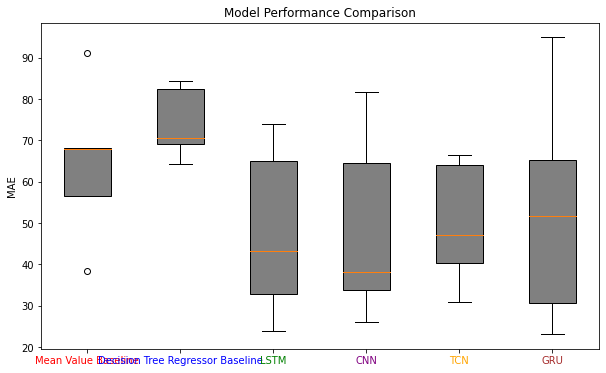

In [512]:
import matplotlib.pyplot as plt

# Define the labels and colors for each model
labels = ["Mean Value", "DTR", "LSTM", "CNN", "TCN", "GRU"]
colors = ["red", "blue", "green", "purple", "orange", "brown"]

# Create a list to store the MAxE for each model in each fold
mae_list = [[] for _ in range(len(labels))]

# Loop through each fold and extract the MAE for each model
for fold in range(len(split_data)):
    train_df_list, train_intubation_time_list, test_df_list, test_intubation_time_list = split_data[fold]
    trainX, trainy = sliding_window(train_df_list, train_intubation_time_list, window_size=25, step_size=1)
    testX, testy = sliding_window(test_df_list, test_intubation_time_list, window_size=25, step_size=1)
    
    # Evaluate each model on the current fold
    mae_list[0].append(mean_value_baseline(trainX, trainy, testX, testy))
    mae_list[1].append(decision_tree_regressor_baseline(trainX, trainy, testX, testy))
    mae_list[2].append(train_and_evaluate_lstm(trainX, trainy, testX, testy))
    mae_list[3].append(train_and_evaluate_cnn(trainX, trainy, testX, testy))
    mae_list[4].append(train_and_evaluate_tcn(trainX, trainy, testX, testy))
    mae_list[5].append(train_and_evaluate_gru(trainX, trainy, testX, testy))

# Create a boxplot to visualize the MAE for each model in each fold
plt.figure(figsize=(10, 6))
plt.boxplot(mae_list, labels=labels, patch_artist=True, boxprops=dict(facecolor="gray"))
plt.ylabel("MAE")
plt.title("Model Performance Comparison")
for i in range(len(labels)):
    plt.setp(plt.gca().get_xticklabels()[i], color=colors[i])
plt.show()


In [ ]:
window_size_list = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65,70,75,80,85,90]

from sklearn.model_selection import GroupKFold

def split_train_test_by_case(df_list, intubation_time_list, n_splits=5):
    case_numbers = []
    for df in df_list:
        case_numbers.append(df['Case Number'].unique()[0])

    group_kfold = GroupKFold(n_splits=n_splits)

    split_data = []

    for train_index, test_index in group_kfold.split(df_list, intubation_time_list, groups=case_numbers):
        train_df_list = [df_list[i] for i in train_index]
        train_intubation_time_list = [intubation_time_list[i] for i in train_index]
        test_df_list = [df_list[i] for i in test_index]
        test_intubation_time_list = [intubation_time_list[i] for i in test_index]

        split_data.append((train_df_list, train_intubation_time_list, test_df_list, test_intubation_time_list))

    return split_data

all_window_size_eval_metrics = []
split_data = split_train_test_by_case(df_list, intubation_time_list)

for window_size in window_size_list:
    print(f"Processing window size {window_size}")
    all_eval_metrics = []
    for fold, (train_df_list, train_intubation_time_list, test_df_list, test_intubation_time_list) in enumerate(split_data):
        trainX, trainy = sliding_window(train_df_list, train_intubation_time_list, window_size=window_size, step_size=1)
        testX, testy = sliding_window(test_df_list, test_intubation_time_list, window_size=window_size, step_size=1)

        # Evaluate mean_value_baseline model
        mean_value_mae = mean_value_baseline(trainX, trainy, testX, testy)
        print(f"Mean Value Baseline MAE: {mean_value_mae}")

        # Evaluate decision_tree_regressor_baseline model
        dtr_mae = decision_tree_regressor_baseline(trainX, trainy, testX, testy)
        print(f"Decision Tree Regressor Baseline MAE: {dtr_mae}")

        # Evaluate LSTM model
        lstm_mae = train_and_evaluate_lstm(trainX, trainy, testX, testy)
        print(f"LSTM MAE: {lstm_mae}")

        # Evaluate CNN model
        cnn_mae = train_and_evaluate_cnn(trainX, trainy, testX, testy)
        print(f"CNN MAE: {cnn_mae}")

        # Evaluate TCN model
        tcn_mae = train_and_evaluate_tcn(trainX, trainy, testX, testy)
        print(f"TCN MAE: {tcn_mae}")

        # Evaluate GRU model
        gru_mae = train_and_evaluate_gru(trainX, trainy, testX, testy)
        print(f"GRU MAE: {gru_mae}")

        eval_metrics = {"mean_value_baseline": mean_value_mae, "decision_tree_regressor_baseline": dtr_mae, "lstm": lstm_mae, "cnn": cnn_mae, "tcn": tcn_mae, "gru": gru_mae}
        all_eval_metrics.append(eval_metrics)

    all_window_size_eval_metrics.append({f"window_size_{window_size}": all_eval_metrics})

# Print the evaluation metrics for all window sizes
for window_size_eval_metrics in all_window_size_eval_metrics:
    window_size = list(window_size_eval_metrics.keys())[0]
    eval_metrics = list(window_size_eval_metrics.values())[0]
    print(f"{window_size} evaluation metrics: {eval_metrics}")


In [9]:
all_metrics = {'window_size_15': [{'mean_value_baseline': 66.9089008028144, 'decision_tree_regressor_baseline': 80.42474777903777, 'lstm': 65.50676, 'cnn': 65.35687, 'tcn': 67.10433, 'gru': 67.079346}, {'mean_value_baseline': 64.89984128918053, 'decision_tree_regressor_baseline': 71.03622074709594, 'lstm': 28.032999, 'cnn': 28.371555, 'tcn': 34.443207, 'gru': 24.921562}, {'mean_value_baseline': 43.99748370678394, 'decision_tree_regressor_baseline': 73.11254297727115, 'lstm': 46.707344, 'cnn': 41.470196, 'tcn': 32.81941, 'gru': 55.687042}, {'mean_value_baseline': 54.20050230258849, 'decision_tree_regressor_baseline': 68.58482354326947, 'lstm': 31.742008, 'cnn': 36.831886, 'tcn': 46.000587, 'gru': 31.163261}, {'mean_value_baseline': 93.0753530807133, 'decision_tree_regressor_baseline': 92.70055945462818, 'lstm': 75.0633, 'cnn': 81.70188, 'tcn': 73.410324, 'gru': 93.99526}]
,'window_size_20': [{'mean_value_baseline': 67.44082766097958, 'decision_tree_regressor_baseline': 84.27568500577323, 'lstm': 65.10713, 'cnn': 64.417145, 'tcn': 66.57772, 'gru': 66.07758}, {'mean_value_baseline': 66.02390729788259, 'decision_tree_regressor_baseline': 66.97838609389838, 'lstm': 25.344273, 'cnn': 25.680632, 'tcn': 42.439648, 'gru': 23.588377}, {'mean_value_baseline': 40.999516862103725, 'decision_tree_regressor_baseline': 73.21626067388625, 'lstm': 39.606728, 'cnn': 35.387047, 'tcn': 30.811464, 'gru': 53.311436}, {'mean_value_baseline': 55.75571898410195, 'decision_tree_regressor_baseline': 67.92477818539268, 'lstm': 32.515194, 'cnn': 40.784954, 'tcn': 44.585537, 'gru': 30.968706}, {'mean_value_baseline': 92.06256556709278, 'decision_tree_regressor_baseline': 92.9014660014884, 'lstm': 81.61715, 'cnn': 74.359634, 'tcn': 77.53145, 'gru': 94.55266}]
,'window_size_25': [{'mean_value_baseline': 67.9986597156245, 'decision_tree_regressor_baseline': 82.36070665376278, 'lstm': 65.313896, 'cnn': 63.278843, 'tcn': 67.94314, 'gru': 66.904724}, {'mean_value_baseline': 68.16591630703617, 'decision_tree_regressor_baseline': 70.36786542943395, 'lstm': 25.971388, 'cnn': 31.72184, 'tcn': 39.420574, 'gru': 23.14596}, {'mean_value_baseline': 38.41024607961828, 'decision_tree_regressor_baseline': 69.12099208615042, 'lstm': 49.76569, 'cnn': 29.00501, 'tcn': 35.46423, 'gru': 54.15686}, {'mean_value_baseline': 56.46126877920968, 'decision_tree_regressor_baseline': 63.35104672023228, 'lstm': 33.663372, 'cnn': 36.89966, 'tcn': 39.814957, 'gru': 30.747114}, {'mean_value_baseline': 91.13808499284467, 'decision_tree_regressor_baseline': 84.5357049050139, 'lstm': 93.84345, 'cnn': 84.36187, 'tcn': 73.10583, 'gru': 94.41598}]
,'window_size_30': [{'mean_value_baseline': 68.46311637017605, 'decision_tree_regressor_baseline': 80.27999543627779, 'lstm': 66.16419, 'cnn': 62.77207, 'tcn': 66.30401, 'gru': 65.59656}, {'mean_value_baseline': 70.44579038864526, 'decision_tree_regressor_baseline': 63.322216021708954, 'lstm': 24.590006, 'cnn': 22.344786, 'tcn': 34.051487, 'gru': 22.990438}, {'mean_value_baseline': 35.48584823721594, 'decision_tree_regressor_baseline': 72.58363132872992, 'lstm': 38.947224, 'cnn': 30.603174, 'tcn': 30.023104, 'gru': 52.83307}, {'mean_value_baseline': 57.018785178661346, 'decision_tree_regressor_baseline': 61.992022120952605, 'lstm': 32.43713, 'cnn': 40.843647, 'tcn': 41.503723, 'gru': 30.528357}, {'mean_value_baseline': 89.90370708472628, 'decision_tree_regressor_baseline': 74.59320517520587, 'lstm': 93.68697, 'cnn': 73.669495, 'tcn': 69.48719, 'gru': 94.20987}]
,'window_size_35': [{'mean_value_baseline': 68.81147902619605, 'decision_tree_regressor_baseline': 82.43738769705779, 'lstm': 62.71384, 'cnn': 63.224506, 'tcn': 62.86696, 'gru': 68.30338}, {'mean_value_baseline': 72.9510286178323, 'decision_tree_regressor_baseline': 55.73071584136644, 'lstm': 23.864296, 'cnn': 28.0135, 'tcn': 36.321007, 'gru': 22.482273}, {'mean_value_baseline': 31.969124669614047, 'decision_tree_regressor_baseline': 71.8459015840329, 'lstm': 40.557053, 'cnn': 23.976574, 'tcn': 32.84367, 'gru': 53.601326}, {'mean_value_baseline': 57.423334516327955, 'decision_tree_regressor_baseline': 63.89931153922245, 'lstm': 30.697489, 'cnn': 40.635574, 'tcn': 40.81285, 'gru': 30.116621}, {'mean_value_baseline': 88.22470527992323, 'decision_tree_regressor_baseline': 81.14895603754749, 'lstm': 67.59318, 'cnn': 78.51211, 'tcn': 71.176994, 'gru': 93.50897}]
,'window_size_40': [{'mean_value_baseline': 69.104436304491, 'decision_tree_regressor_baseline': 79.5704993608702, 'lstm': 66.388626, 'cnn': 59.227898, 'tcn': 61.70279, 'gru': 68.7066}, {'mean_value_baseline': 75.03745750252527, 'decision_tree_regressor_baseline': 75.1557410291133, 'lstm': 25.150812, 'cnn': 31.486738, 'tcn': 49.39621, 'gru': 21.687664}, {'mean_value_baseline': 29.848130098771584, 'decision_tree_regressor_baseline': 71.78065327324386, 'lstm': 42.964966, 'cnn': 24.680098, 'tcn': 33.453247, 'gru': 56.073902}, {'mean_value_baseline': 56.905105810899, 'decision_tree_regressor_baseline': 64.42592205634485, 'lstm': 31.404125, 'cnn': 35.38837, 'tcn': 42.658825, 'gru': 29.666853}, {'mean_value_baseline': 86.54585641329406, 'decision_tree_regressor_baseline': 80.92768548746578, 'lstm': 56.34616, 'cnn': 76.20387, 'tcn': 68.80172, 'gru': 95.77643}]
,'window_size_45': [{'mean_value_baseline': 69.48386568580169, 'decision_tree_regressor_baseline': 78.02216409985485, 'lstm': 67.020325, 'cnn': 61.083496, 'tcn': 61.256638, 'gru': 71.42053}, {'mean_value_baseline': 76.45984971573584, 'decision_tree_regressor_baseline': 64.97397151576818, 'lstm': 24.50247, 'cnn': 33.429523, 'tcn': 49.880615, 'gru': 21.04056}, {'mean_value_baseline': 27.58063620737154, 'decision_tree_regressor_baseline': 68.94975638062986, 'lstm': 39.422337, 'cnn': 21.505424, 'tcn': 31.23251, 'gru': 54.24637}, {'mean_value_baseline': 56.892853418986, 'decision_tree_regressor_baseline': 69.21278268862993, 'lstm': 30.068794, 'cnn': 33.649494, 'tcn': 37.907574, 'gru': 29.687475}, {'mean_value_baseline': 84.97411392081497, 'decision_tree_regressor_baseline': 79.2884933765118, 'lstm': 81.63593, 'cnn': 71.979614, 'tcn': 77.485146, 'gru': 98.02661}]
,'window_size_50': [{'mean_value_baseline': 69.67498714616073, 'decision_tree_regressor_baseline': 75.18703135819334, 'lstm': 66.35479, 'cnn': 62.359566, 'tcn': 64.55756, 'gru': 73.89494}, {'mean_value_baseline': 77.6151989271056, 'decision_tree_regressor_baseline': 57.7093869155308, 'lstm': 22.240736, 'cnn': 38.15351, 'tcn': 29.349854, 'gru': 20.046612}, {'mean_value_baseline': 26.12212897207763, 'decision_tree_regressor_baseline': 68.56064083774167, 'lstm': 26.042007, 'cnn': 20.108797, 'tcn': 32.284523, 'gru': 55.44594}, {'mean_value_baseline': 57.73418126400048, 'decision_tree_regressor_baseline': 58.645011232927516, 'lstm': 30.237703, 'cnn': 35.33326, 'tcn': 43.465645, 'gru': 30.193096}, {'mean_value_baseline': 83.1160944529942, 'decision_tree_regressor_baseline': 70.57403975725174, 'lstm': 61.519035, 'cnn': 68.04219, 'tcn': 67.01023, 'gru': 101.09005}]
,'window_size_55': [{'mean_value_baseline': 69.58877868496323, 'decision_tree_regressor_baseline': 80.83520881481209, 'lstm': 67.82774, 'cnn': 56.412518, 'tcn': 58.201187, 'gru': 80.432945}, {'mean_value_baseline': 78.00279607109844, 'decision_tree_regressor_baseline': 56.032110877215544, 'lstm': 21.147734, 'cnn': 26.023495, 'tcn': 35.954308, 'gru': 18.977455}, {'mean_value_baseline': 25.904515959999777, 'decision_tree_regressor_baseline': 69.67716093496843, 'lstm': 30.760223, 'cnn': 18.683372, 'tcn': 32.990955, 'gru': 68.469086}, {'mean_value_baseline': 59.398489907149866, 'decision_tree_regressor_baseline': 61.84475118826821, 'lstm': 28.77013, 'cnn': 31.893692, 'tcn': 37.641808, 'gru': 29.134586}, {'mean_value_baseline': 81.15359554112514, 'decision_tree_regressor_baseline': 65.75082490154516, 'lstm': 71.44035, 'cnn': 81.909676, 'tcn': 79.520836, 'gru': 111.8317}]
,'window_size_60': [{'mean_value_baseline': 69.2133032605539, 'decision_tree_regressor_baseline': 80.21065253629664, 'lstm': 67.90888, 'cnn': 59.72444, 'tcn': 61.71137, 'gru': 89.805145}, {'mean_value_baseline': 77.73011530181508, 'decision_tree_regressor_baseline': 51.171211713626064, 'lstm': 17.987087, 'cnn': 10.179418, 'tcn': 42.16778, 'gru': 17.212145}, {'mean_value_baseline': 25.724081657515843, 'decision_tree_regressor_baseline': 62.89762019921487, 'lstm': 26.819925, 'cnn': 17.302113, 'tcn': 38.160583, 'gru': 65.66324}, {'mean_value_baseline': 61.47639130167878, 'decision_tree_regressor_baseline': 67.77194363809045, 'lstm': 28.726952, 'cnn': 31.268515, 'tcn': 32.631485, 'gru': 28.895473}, {'mean_value_baseline': 78.7887742285635, 'decision_tree_regressor_baseline': 77.00536307166604, 'lstm': 85.65836, 'cnn': 66.84596, 'tcn': 70.49058, 'gru': 112.9451}]}


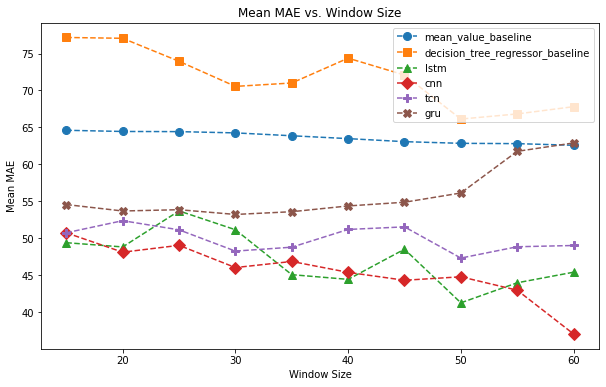

In [15]:
import matplotlib.pyplot as plt

# Sample all_metrics dictionary structure


models = ["mean_value_baseline", "decision_tree_regressor_baseline", "lstm", "cnn", "tcn", "gru"]
window_sizes = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
markers = ["o", "s", "^", "D", "P", "X"]
mean_maes = {model: [] for model in models}

for window_size in window_sizes:
    window_key = f"window_size_{window_size}"
    metrics_list = all_metrics[window_key]
    
    for model in models:
        mean_mae = sum([metrics[model] for metrics in metrics_list]) / len(metrics_list)
        mean_maes[model].append(mean_mae)
plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    plt.plot(window_sizes, mean_maes[model], label=model, marker=markers[i], linestyle='--', markersize=8)

plt.xlabel("Window Size")
plt.ylabel("Mean MAE")
plt.title("Mean MAE vs. Window Size")
plt.legend()
plt.show()
